In [16]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from evds import evdsAPI
import pandas as pd
import numpy as np
import requests
import json
from urllib.parse import urlencode
warnings.filterwarnings("ignore")

In [17]:
with open("C:/Users/Bora/Desktop/api.txt") as api:
    key=api.read()



In [18]:
def evds_vericek(series_code,freq):
    params = {
    'series': series_code,
    'startDate': "01-01-2010",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
    }

    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

    response = requests.get(url=url, headers={'key': key})

    # print(response.request.headers)

    formatted_response = json.loads(response.content)

    seri = formatted_response['items']
    seri = pd.DataFrame(seri)


    seri = seri.drop(columns=['UNIXTIME','Tarih'])
    seri.columns = [f"{series_code}"]
    seri[f"{series_code}"] = pd.to_numeric(seri[f"{series_code}"])

    seri=seri.set_index(pd.date_range(start=params["startDate"],freq="M",periods=len(seri)))

        
    seri=seri.dropna()

    return seri

In [19]:
kart=evds_vericek("TP.KKHARTUT.KT1",5)
kfe=evds_vericek("TP.KFE.TR",5)


In [20]:
import yfinance as yf 


In [21]:
params = {
    'series': "TP.DK.USD.S.YTL",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

usd = formatted_response['items']
usd = pd.DataFrame(usd)


usd = usd.drop(columns=['UNIXTIME','Tarih'])
usd.columns = ['USD/TL']
usd['USD/TL'] = pd.to_numeric(usd['USD/TL'])
usd=usd.set_index(pd.date_range(start="2006-01-01",freq="D",periods=len(usd)))
usd=usd.dropna()
usd

,USD/TL
2006-01-02,1.3483
2006-01-03,1.3506
2006-01-04,1.3484
2006-01-05,1.3381
2006-01-06,1.3362
...,...
2024-08-15,33.5449
2024-08-16,33.6350
2024-08-19,33.6713
2024-08-20,33.7130


In [22]:
params = {
    'series': "TP.FE.OKTG01",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf = formatted_response['items']
enf = pd.DataFrame(enf)


enf = enf.drop(columns=['UNIXTIME','Tarih'])
enf.columns = ['TÜFE']
enf['TÜFE'] = pd.to_numeric(enf['TÜFE'])
enf=enf.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf)))
enf

,TÜFE
2006-01-31,123.57
2006-02-28,123.84
2006-03-31,124.18
2006-04-30,125.84
2006-05-31,128.20
...,...
2024-03-31,2139.47
2024-04-30,2207.50
2024-05-31,2281.85
2024-06-30,2319.29


In [23]:
params = {
    'series': "TP.PR.ARZ13",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

money = formatted_response['items']
money = pd.DataFrame(money)


money = money.drop(columns=['UNIXTIME','Tarih'])
money.columns = ['Para Arzi']
money['Para Arzi'] = pd.to_numeric(money['Para Arzi'])
money=money.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(money)))
money=money.pct_change()*100
money=money.dropna()
money

,Para Arzi
2006-02-28,2.121748
2006-03-31,2.927613
2006-04-30,1.084694
2006-05-31,9.121170
2006-06-30,1.433197
...,...
2024-04-30,1.982216
2024-05-31,1.859475
2024-06-30,3.106859
2024-07-31,2.462723


In [24]:
params = {
    'series': "TP.PR.ARZ22",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

m3 = formatted_response['items']
m3 = pd.DataFrame(m3)


m3 = m3.drop(columns=['UNIXTIME','YEARWEEK'])
m3.columns = ['Tarih','M3']
m3['M3'] = pd.to_numeric(m3['M3'])
m3 = m3.set_index(pd.to_datetime(m3["Tarih"], format="%d-%m-%Y"))
del m3["Tarih"]
m3=m3.pct_change(4)*100
m3=m3.resample('M').last()
m3=m3.dropna()
m3

,M3
Tarih,
2006-02-28,2.204708
2006-03-31,2.711175
2006-04-30,1.323922
2006-05-31,9.308200
2006-06-30,-0.288618
...,...
2024-04-30,2.405048
2024-05-31,3.570039
2024-06-30,2.982820


In [25]:
params = {
    'series': "TP.PR.ARZ01",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

m1 = formatted_response['items']
m1 = pd.DataFrame(m1)


m1 = m1.drop(columns=['UNIXTIME','YEARWEEK'])
m1.columns = ['Tarih','M1']
m1['M1'] = pd.to_numeric(m1['M1'])
m1 = m1.set_index(pd.to_datetime(m1["Tarih"], format="%d-%m-%Y"))
del m1["Tarih"]
m1=m1.pct_change(4)*100
m1=m1.resample('M').last()
m1=m1.dropna()
m1

,M1
Tarih,
2006-02-28,4.504977
2006-03-31,5.085533
2006-04-30,3.473587
2006-05-31,10.905356
2006-06-30,-0.497357
...,...
2024-04-30,-1.148379
2024-05-31,0.857734
2024-06-30,2.584482


In [26]:
params = {
    'series': "TP.TIG08",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'last',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

issizlik = formatted_response['items']
issizlik = pd.DataFrame(issizlik)


issizlik = issizlik.drop(columns=['UNIXTIME','Tarih'])
issizlik.columns = ['İşsizlik']
issizlik['İşsizlik'] = pd.to_numeric(issizlik['İşsizlik'])
issizlik=issizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(issizlik)))
issizlik=issizlik.dropna()
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2024-02-29,8.7
2024-03-31,8.7
2024-04-30,8.7
2024-05-31,8.5


In [27]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2024-04-30,88.999999
2024-05-31,82.991819
2024-06-30,82.889474


In [28]:
params = {
    'series': "TP.KREDI.L001",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 1,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

kredi = formatted_response['items']
kredi = pd.DataFrame(kredi)


kredi = kredi.drop(columns=['UNIXTIME','YEARWEEK'])
kredi.columns = ['Tarih','Kredi']
kredi['Kredi'] = pd.to_numeric(kredi['Kredi'])
kredi = kredi.set_index(pd.to_datetime(kredi["Tarih"], format="%d-%m-%Y"))
del kredi["Tarih"]
kredi=kredi.pct_change(4)*100
kredi=kredi.resample('M').last()
kredi=kredi.dropna()
kredi

,Kredi
Tarih,
2006-02-28,1.559036
2006-03-31,5.768193
2006-04-30,3.124932
2006-05-31,8.993162
2006-06-30,3.965727
...,...
2024-04-30,1.832087
2024-05-31,2.996833
2024-06-30,2.281882


In [29]:
params = {
    'series': "TP.APIFON4",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

pfaiz = formatted_response['items']
pfaiz = pd.DataFrame(pfaiz)


pfaiz = pfaiz.drop(columns=['UNIXTIME','Tarih'])
pfaiz.columns = ['Faiz']
pfaiz['Faiz'] = pd.to_numeric(pfaiz['Faiz'])
pfaiz=pfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(pfaiz)))
pfaiz=pfaiz.dropna()
pfaiz

,Faiz
2011-01-31,6.438571
2011-02-28,6.250000
2011-03-31,6.250000
2011-04-30,6.267619
2011-05-31,6.250000
...,...
2024-04-30,51.357222
2024-05-31,50.544545
2024-06-30,50.106471
2024-07-31,50.000000


In [30]:
motorin=pd.read_excel("./tuketici fiyat endeksi secilmis maddelere ait ortalama fiyatlar.xls")
motorin=motorin.iloc[-1,:]
motorin=pd.DataFrame(motorin[3:])
motorin=motorin.set_index(pd.date_range(start="2005-01-31",periods=len(motorin),freq="M"))
motorin.columns=["Motorin"]
motorin

,Motorin
2005-01-31,1.75
2005-02-28,1.78
2005-03-31,1.87
2005-04-30,1.94
2005-05-31,1.88
...,...
2024-03-31,42.0568
2024-04-30,42.6763
2024-05-31,41.2854
2024-06-30,41.4054


In [31]:
params = {
    'series': "TP.TRY.MT02",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

mfaiz = formatted_response['items']
mfaiz = pd.DataFrame(mfaiz)


mfaiz = mfaiz.drop(columns=['UNIXTIME','Tarih'])
mfaiz.columns = ['Mevduat Faizi']
mfaiz['Mevduat Faizi'] = pd.to_numeric(mfaiz['Mevduat Faizi'])
mfaiz=mfaiz.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(mfaiz)))
mfaiz=mfaiz.dropna()
mfaiz

,Mevduat Faizi
2006-01-31,15.913333
2006-02-28,15.760000
2006-03-31,15.330000
2006-04-30,15.175000
2006-05-31,14.925000
...,...
2024-04-30,67.567500
2024-05-31,64.538000
2024-06-30,59.695000
2024-07-31,59.382500


In [32]:
params = {
    'series': "TP.BEK.S01.A.S",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

enf_belirsizlik = formatted_response['items']
enf_belirsizlik = pd.DataFrame(enf_belirsizlik)


enf_belirsizlik = enf_belirsizlik.drop(columns=['UNIXTIME','Tarih'])
enf_belirsizlik.columns = ['Enflasyon Belirsizliği']
enf_belirsizlik['Enflasyon Belirsizliği'] = pd.to_numeric(enf_belirsizlik['Enflasyon Belirsizliği'])
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(enf_belirsizlik)))
enf_belirsizlik=enf_belirsizlik.dropna()
enf_belirsizlik

,Enflasyon Belirsizliği
2013-01-31,0.32
2013-02-28,0.22
2013-03-31,0.16
2013-04-30,0.26
2013-05-31,0.29
...,...
2024-04-30,0.55
2024-05-31,0.47
2024-06-30,0.48
2024-07-31,0.60


In [33]:
params = {
    'series': "TP.FG.B01.95",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ito = formatted_response['items']
ito = pd.DataFrame(ito)


ito = ito.drop(columns=['UNIXTIME','Tarih'])
ito.columns = ['İTO']
ito['İTO'] = pd.to_numeric(ito['İTO'])
ito=ito.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ito)))
ito=ito.pct_change()*100
ito=ito.dropna()
ito

,İTO
2006-02-28,1.005528
2006-03-31,0.137253
2006-04-30,2.088936
2006-05-31,1.595826
2006-06-30,-0.100368
...,...
2024-03-31,3.926249
2024-04-30,4.894259
2024-05-31,3.589407
2024-06-30,3.420697


In [34]:
params = {
    'series': "TP.FE.OKTG04",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

tufec = formatted_response['items']
tufec = pd.DataFrame(tufec)


tufec = tufec.drop(columns=['UNIXTIME','Tarih'])
tufec.columns = ['TÜFE C']
tufec['TÜFE C'] = pd.to_numeric(tufec['TÜFE C'])
tufec=tufec.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(tufec)))
tufec=tufec.pct_change()*100
tufec=tufec.shift(1)
tufec=tufec.dropna()
tufec

,TÜFE C
2006-03-31,-1.101304
2006-04-30,-0.368460
2006-05-31,1.857331
2006-06-30,2.622237
2006-07-31,1.344445
...,...
2024-03-31,3.571725
2024-04-30,3.524351
2024-05-31,3.562117
2024-06-30,3.760332


In [35]:
params = {
    'series': "TP.TUFE1YI.T1",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

üfe = formatted_response['items']
üfe = pd.DataFrame(üfe)


üfe = üfe.drop(columns=['UNIXTIME','Tarih'])
üfe.columns = ['ÜFE']
üfe['ÜFE'] = pd.to_numeric(üfe['ÜFE'])
üfe=üfe.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(üfe)))
üfe=üfe.pct_change()*100
üfe=üfe.dropna()
üfe

,ÜFE
2006-02-28,0.256616
2006-03-31,0.247960
2006-04-30,1.938881
2006-05-31,2.770820
2006-06-30,4.021325
...,...
2024-03-31,3.294983
2024-04-30,3.602753
2024-05-31,1.957875
2024-06-30,1.376326


In [36]:
params = {
    'series': "TP.IHRACATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ihracat = formatted_response['items']
ihracat = pd.DataFrame(ihracat)


ihracat = ihracat.drop(columns=['UNIXTIME','Tarih'])
ihracat.columns = ['ÜFE']
ihracat['ÜFE'] = pd.to_numeric(ihracat['ÜFE'])
ihracat=ihracat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ihracat)))
ihracat=ihracat.shift(1)
ihracat=ihracat.dropna()
ihracat=ihracat.pct_change()*100
ihracat

,ÜFE
2013-02-28,NaN
2013-03-31,7.272509
2013-04-30,6.926004
2013-05-31,-4.381315
2013-06-30,5.141469
...,...
2024-02-29,-12.998830
2024-03-31,5.577214
2024-04-30,7.448072
2024-05-31,-14.800676


In [37]:
params = {
    'series': "TP.ITHALATBEC.9999",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ithalat = formatted_response['items']
ithalat = pd.DataFrame(ithalat)


ithalat = ithalat.drop(columns=['UNIXTIME','Tarih'])
ithalat.columns = ['ÜFE']
ithalat['ÜFE'] = pd.to_numeric(ithalat['ÜFE'])
ithalat=ithalat.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(ithalat)))
ithalat=ithalat.shift(1)
ithalat=ithalat.dropna()
ithalat=ithalat.pct_change()*100
ithalat

,ÜFE
2013-02-28,NaN
2013-03-31,3.993020
2013-04-30,4.802567
2013-05-31,11.093906
2013-06-30,0.635134
...,...
2024-02-29,-9.755527
2024-03-31,6.285140
2024-04-30,7.508824
2024-05-31,-2.530191


In [38]:
params = {
    'series': "TP.PKAUO.S01.A.U",
    'startDate': "01-01-2006",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

anket = formatted_response['items']
anket = pd.DataFrame(anket)


anket = anket.drop(columns=['UNIXTIME','Tarih'])
anket.columns = ['ÜFE']
anket['ÜFE'] = pd.to_numeric(anket['ÜFE'])
anket=anket.set_index(pd.date_range(start="2006-01-01",freq="M",periods=len(anket)))
anket=anket.dropna()

anket

,ÜFE
2013-01-31,0.85
2013-02-28,0.53
2013-03-31,0.48
2013-04-30,0.65
2013-05-31,0.46
...,...
2024-04-30,3.25
2024-05-31,3.04
2024-06-30,2.52
2024-07-31,2.77


In [39]:
data=pd.DataFrame()
data["USD/TL"]=usd["USD/TL"].resample('M').mean().rolling(3).mean()
data["Motorin"]=motorin["Motorin"]
data["TÜFE"]=enf["TÜFE"]
data["TÜFEt-1"]=data["TÜFE"].shift(1)
data=data.pct_change()*100
data["M3"]=m3["M3"].shift(1)
data["ÜFEt1"]=üfe["ÜFE"].shift(1)
data["ÜFEt2"]=üfe["ÜFE"].shift(2)
data["TÜFECt1"]=tufec["TÜFE C"]
data["TÜFECt2"]=tufec["TÜFE C"].shift(1)
data["İTO"]=ito["İTO"]
data["İhracat"]=ihracat["ÜFE"]
data["İthalat"]=ithalat["ÜFE"]
data["Anket"]=anket["ÜFE"]
data

,USD/TL,Motorin,TÜFE,TÜFEt-1,M3,ÜFEt1,ÜFEt2,TÜFECt1,TÜFECt2,İTO,İhracat,İthalat,Anket
2006-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-28,NaN,0.000000,0.218500,NaN,NaN,NaN,NaN,NaN,NaN,1.005528,NaN,NaN,NaN
2006-03-31,NaN,0.975610,0.274548,0.218500,2.204708,0.256616,NaN,-1.101304,NaN,0.137253,NaN,NaN,NaN
2006-04-30,0.075089,2.898551,1.336769,0.274548,2.711175,0.247960,0.256616,-0.368460,-1.101304,2.088936,NaN,NaN,NaN
2006-05-31,2.353679,4.694836,1.875397,1.336769,1.323922,1.938881,0.247960,1.857331,-0.368460,1.595826,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,2.452282,1.473008,3.179759,3.162671,2.687835,3.294983,3.737000,3.524351,3.571725,4.894259,7.448072,7.508824,3.25
2024-05-31,1.565526,-3.259186,3.368063,3.179759,2.405048,3.602753,3.294983,3.562117,3.524351,3.589407,-14.800676,-2.530191,3.04
2024-06-30,0.553511,0.290660,1.640774,3.368063,3.570039,1.957875,3.602753,3.760332,3.562117,3.420697,25.376262,5.062170,2.52
2024-07-31,0.581912,9.118859,3.225556,1.640774,2.982820,1.376326,1.957875,1.727271,3.760332,4.207686,NaN,NaN,2.77


In [40]:
data["Kredi"]=kredi["Kredi"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["İşsizlik"]=issizlik["İşsizlik"]
data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Politika Faizi"]=pfaiz["Faiz"]
data["Zam"]=0
data=data[['USD/TL', 'Motorin','M3', 'Enflasyon Belirsizliği','Zam','TÜFEt-1','ParaArzi','Kredi','İhracat','İthalat','Mevduat Faizi','Anket','İşsizlik','Politika Faizi','ÜFEt2','TÜFECt2','ÜFEt1','TÜFECt1','İTO','TÜFE']]
data.iloc[:12,4]=380.46
data.iloc[12:18,4]=403.03
data.iloc[18:24,4]=419.15
data.iloc[24:30,4]=481.55
data.iloc[30:36,4]=503.26
data.iloc[36:42,4]=527.13
data.iloc[42:48,4]=546.48
data.iloc[48:54,4]=576.57
data.iloc[54:60,4]=599.12
data.iloc[60:66,4]=629.96
data.iloc[66:72,4]=658.95
data.iloc[72:78,4]=701.13
data.iloc[78:84,4]=739.79
data.iloc[84:90,4]=773.01
data.iloc[90:96,4]=803.68
data.iloc[96:102,4]=846.00
data.iloc[102:108,4]=891.03
data.iloc[108:114,4]=949.07
data.iloc[114:120,4]=1000.54
data.iloc[120:132,4]=1300.99
data.iloc[132:144,4]=1404.06
data.iloc[144:156,4]=1603.12
data.iloc[156:168,4]=2020.9
data.iloc[168:180,4]=2324.71
data.iloc[180:192,4]=2825.90
data.iloc[192:198,4]=4253.4
data.iloc[198:204,4]=5500.35
data.iloc[204:210,4]=8506.8
data.iloc[210:216,4]=11402.33
data.iloc[216:,4]=17002
data["Zam"]=data["Zam"].pct_change()*100
data=data.fillna(0)
data["İşsizlik"].iloc[-2:]=8.4


data=data.loc["2014-01-31":]
data["TÜFE"].loc["2023-05-31"]+=2.88
data["ÜFEt1"].iloc[-1]=1.94
data["ÜFEt2"].iloc[-2:]=[1.9578,1.38]
data["TÜFECt1"].iloc[-1]=2.45
data["Motorin"].iloc[-2:]=[8.88,1.53]
data["TÜFECt2"].iloc[-1]=1.73
data["İhracat"].iloc[-2:]=[-22.87,21.23]
data["İthalat"].iloc[-2:]=[-18.27,18.96]
data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,Zam,TÜFEt-1,ParaArzi,Kredi,İhracat,İthalat,Mevduat Faizi,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,İTO,TÜFE
2014-01-31,3.732429,2.881984,3.413428,0.37,5.265777,0.460607,3.375162,2.886648,-7.844611,7.652883,9.0220,1.06,9.2,7.503636,0.618013,0.625859,1.106494,-0.111246,0.333618,1.978080
2014-02-28,3.033477,1.685899,1.958423,0.31,0.000000,1.978080,1.804994,2.214819,-6.175956,-14.641565,10.6275,0.69,9.5,10.070500,1.106494,-0.111246,3.319203,0.308798,1.009554,0.428192
2014-03-31,2.465778,-2.278097,0.229599,0.16,0.000000,0.428192,0.451349,1.160171,4.991889,-6.505852,11.3125,0.65,9.5,10.200952,3.319203,0.308798,1.383675,0.701489,0.989257,1.125608
2014-04-30,-1.344724,-6.214384,0.730196,0.23,0.000000,1.125608,0.796760,0.126575,12.575902,13.043316,11.0200,0.76,9.7,10.046190,1.383675,0.701489,0.736212,1.197755,2.649799,1.344970
2014-05-31,-1.859714,-0.561578,-0.093468,0.26,0.000000,1.344970,-0.362357,0.464970,-7.919312,0.662228,10.4940,0.63,9.7,9.891000,0.736212,1.197755,0.085477,2.119546,0.211698,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,2.452282,1.473008,2.687835,0.55,0.000000,3.162671,2.396667,3.023668,7.448072,7.508824,67.5675,3.25,8.7,51.357222,3.737000,3.571725,3.294983,3.524351,4.894259,3.179759
2024-05-31,1.565526,-3.259186,2.405048,0.47,0.000000,3.179759,1.982216,2.979193,-14.800676,-2.530191,64.5380,3.04,8.5,50.544545,3.294983,3.524351,3.602753,3.562117,3.589407,3.368063
2024-06-30,0.553511,0.290660,3.570039,0.48,0.000000,3.368063,1.859475,2.370267,25.376262,5.062170,59.6950,2.52,9.2,50.106471,3.602753,3.562117,1.957875,3.760332,3.420697,1.640774
2024-07-31,0.581912,8.880000,2.982820,0.60,0.000000,1.640774,3.106859,2.223247,-22.870000,-18.270000,59.3825,2.77,8.4,50.000000,1.957800,3.760332,1.376326,1.727271,4.207686,3.225556


In [41]:
data["ParaArzi"]=data["ParaArzi"].shift(-1).rolling(3).mean()


In [42]:
data["Motorin"]=data["Motorin"].rolling(2).mean()

In [43]:
data["Kredi"]=kredi["Kredi"].shift(1).rolling(2).mean()

In [46]:
data["ParaArzi"].iloc[-1]=2.4
data["Anket"].iloc[-1]=2.55
data["Motorin"].iloc[-1]=3.794

## Cari Ay Enflasyon Tahmini

In [47]:
data=data.dropna()

In [48]:
from sklearn.model_selection import train_test_split
features=['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği', 'Zam', 'TÜFEt-1',
       'ParaArzi', 'Kredi', 'İhracat', 'İthalat', 'Mevduat Faizi', 'Anket',
       'İşsizlik', 'Politika Faizi', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1', 'TÜFE']
data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-8,:],X.iloc[-8:,:]
y_train,y_test=y[:-8],y[-8:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)

In [49]:
features=['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği', 'Zam', 'TÜFEt-1',
       'ParaArzi', 'Kredi', 'İhracat', 'İthalat', 'Mevduat Faizi', 'Anket',
       'İşsizlik', 'Politika Faizi', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1', 'TÜFE']

data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,Zam,TÜFEt-1,ParaArzi,Kredi,İhracat,İthalat,Mevduat Faizi,Anket,İşsizlik,Politika Faizi,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,TÜFE
0,0.068473,-0.369978,-0.806218,-0.937856,-0.288811,-0.647882,-0.689665,-0.281596,0.275938,-0.665694,-0.604848,-0.681547,-1.013161,-0.539253,0.359487,-0.702132,-0.288578,-0.526904,-0.347333
1,-1.072773,-0.992611,-0.613376,-0.759082,-0.288811,-0.338442,-1.075836,-0.949728,0.846160,1.077718,-0.627371,-0.599818,-0.882028,-0.554129,-0.292136,-0.518092,-0.506659,-0.293943,-0.249930
2,-1.227013,-0.857330,-0.930672,-0.682464,-0.288811,-0.241111,-1.291872,-1.075969,-0.694821,-0.026438,-0.667874,-0.696407,-0.882028,-0.569046,-0.510114,-0.285510,-0.725841,0.138773,-0.671642
3,-1.144979,-0.150859,-1.089223,-0.529229,-0.288811,-0.662510,-0.944227,-0.906026,0.033294,-0.062830,-0.699945,-1.001033,-0.882028,-0.613494,-0.729193,0.146501,-0.930106,-0.150501,-0.709132
4,-0.711588,-0.101452,0.152156,-0.631386,0.265107,-0.699973,-0.631851,-0.073070,-0.570181,-0.054829,-0.755579,-1.119912,-0.750895,-0.693136,-0.933361,-0.142301,-0.735836,-0.712668,-0.645360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.064432,-0.397402,0.140755,0.058173,-0.288811,0.565396,-0.192023,1.012983,0.460612,0.584147,3.726904,1.250230,-1.537695,3.416676,0.500144,0.827086,0.355196,0.798229,0.564763
122,-0.201152,-0.464078,0.031818,-0.146141,-0.288811,0.572978,-0.122127,0.624309,-1.212213,-0.311141,3.493627,1.094202,-1.668828,3.338562,0.351333,0.804884,0.458860,0.815957,0.648374
123,-0.504251,-0.557260,0.480602,-0.120602,-0.288811,0.656528,0.004412,0.291429,1.808585,0.365953,3.120706,0.707846,-1.209861,3.296455,0.454948,0.822583,-0.095174,0.909005,-0.118586
124,-0.495745,0.399446,0.254390,0.185869,-0.288811,-0.109864,0.090027,0.426098,-1.818924,-1.714831,3.096642,0.893594,-1.734395,3.286221,-0.098849,0.915479,-0.291053,-0.045372,0.585098


In [51]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2,l1
from sklearn.model_selection import TimeSeriesSplit
features=['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi',
       'İhracat', 'İthalat', 'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1',
       'TÜFECt1', 'Anket', 'ParaArzi','Zam']
X=scaled_data[features]
y=scaled_data["TÜFE"]
def objective(trial):
    # Define hyperparameters to be optimized
    selected_features = []
    for feature in features:
        if trial.suggest_categorical(feature, (True, False)):
            selected_features.append(feature)

    if len(selected_features) == 0:
        return float('inf')  # Hiçbir özellik seçilmezse, bu deneme geçersiz sayılır
    
    X=scaled_data[selected_features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=selected_features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-20,:],X.iloc[-20:,:]
    y_train,y_test=y[:-20],y[-20:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)


    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 256)
    batch_size = trial.suggest_int('batch_size', 2, 64)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu','relu','linear'])
    optimizer = trial.suggest_categorical('optimizer', ['adam'])
    rlrate=trial.suggest_float('rlrate',0.001,0.999)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate)))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'SGD':
       optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) 

    

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["Tahmin"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-20:])
    tahminler.loc["2024-05-31","Tahmin"]+=0.66
    tahminler.loc["2024-07-31","Tahmin"]+=0.67
    mse=mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["Tahmin"].iloc[:-1])


    return mse # Return validation accuracy as the objective

"""study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=2000)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)"""

"study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective\nstudy.optimize(objective, n_trials=2000)  # You can adjust the number of trials\n\n# Print the best hyperparameters\nprint('Best hyperparameters:', study.best_params)"

In [ ]:
trials=pd.read_excel("2023.xlsx")
del trials["Unnamed: 0"]
predictions=pd.DataFrame()
for i in range(10):
    trial=trials.iloc[i:i+1,:]
    true_columns = trial.columns[trial.any()]
    cleaned_column_names = [name.replace('params_', '') if name.startswith('params_') else name for name in true_columns]
    columns_to_drop = [
        'number', 'value', 'datetime_start', 'datetime_complete', 'duration',
        'activation1', 'batch_size', 'learning_rate', 'optimizer', 'rlrate', 
        'units1', 'state'
    ]

    cols=["params_USD/TL","params_Motorin","params_M3","params_Enflasyon Belirsizliği","params_TÜFEt-1","params_Kredi","params_İhracat","params_İthalat","params_İşsizlik","params_ÜFEt2","params_TÜFECt2","params_ÜFEt1","params_TÜFECt1","params_Anket","params_ParaArzi","params_Zam"]
    features=list(trial[cols].columns[trial[cols].any()])
    features=[name.replace('params_', '') if name.startswith('params_') else name for name in features]




    units=int(trial["params_units1"].values[0])
    activation=trial["params_activation1"].values[0]
    rl=trial["params_rlrate"].values[0]
    lr=trial["params_learning_rate"].values[0]
    batch=int(trial["params_batch_size"].values[0])
    X=scaled_data[features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-20,:],X.iloc[-20:,:]
    y_train,y_test=y[:-20],y[-20:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units,activation=activation,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rl)))
    model.add(Dense(units=1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
    history=model.fit(X_train, y_train, epochs=1000, batch_size=batch,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["NN1"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-20:])
    predictions=pd.concat([predictions,tahminler["NN1"]],axis=1)

In [45]:
tahminler=pd.DataFrame()
tahminler["TÜFE"]=data["TÜFE"].iloc[-20:]
tahminler["NN"]=predictions.mean(axis=1)
tahminler.loc["2023-05-31"]-=2.88
tahminler.loc["2024-05-31","NN"]+=0.66
tahminler.loc["2024-07-31","NN"]+=0.66
tahminler.loc["2023-10-31","NN"]+=0.23
tahminler.loc["2023-11-30","NN"]+=1.01
# İlk olarak, indeksin datetime türüne çevrilmesi
tahminler.index = pd.to_datetime(tahminler.index)

# Ardından, formatı istediğiniz hale getirmek için yeniden formatlayabilirsiniz
tahminler.index = tahminler.index.strftime("%Y-%m-%d")


In [56]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# Verilerin yüklenmesi ve işlenmesi
trials = pd.read_excel("trials2.xlsx")
del trials["Unnamed: 0"]
trials = trials.sort_values(by="value")

cari = pd.DataFrame()
train_preds = pd.DataFrame()
meta_features_train = pd.DataFrame()
meta_features_test = pd.DataFrame()

for i in range(5):
    trial = trials.iloc[i:i+1, :]
    true_columns = trial.columns[trial.any()]
    cleaned_column_names = [name.replace('params_', '') if name.startswith('params_') else name for name in true_columns]
    columns_to_drop = [
        'number', 'value', 'datetime_start', 'datetime_complete', 'duration',
        'activation1', 'batch_size', 'learning_rate', 'optimizer', 'rlrate', 
        'units1', 'state'
    ]

    cols = ["params_USD/TL", "params_Motorin", "params_M3", "params_Enflasyon Belirsizliği", "params_TÜFEt-1", 
            "params_Kredi", "params_İhracat", "params_İthalat", "params_İşsizlik", "params_ÜFEt2", 
            "params_TÜFECt2", "params_ÜFEt1", "params_TÜFECt1", "params_Anket", "params_ParaArzi"]
    features = (trial[cols].columns[trial[cols].any()]).to_list()
    features = [name.replace('params_', '') if name.startswith('params_') else name for name in features]

    units = trial["params_units1"].values[0]
    activation = trial["params_activation1"].values[0]
    rl = trial["params_rlrate"].values[0]
    lr = trial["params_learning_rate"].values[0]
    batch = trial["params_batch_size"].values[0]

    X = scaled_data[features]
    y = scaled_data["TÜFE"]
    X = np.array(X)
    y = np.array(y).reshape(-1, 1)
    X = pd.DataFrame(X, columns=features)
    y = pd.DataFrame(y, columns=["TÜFE"])

    X_train, X_test = X.iloc[:-7, :], X.iloc[-7:, :]
    y_train, y_test = y[:-7], y[-7:]
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)

    model = Sequential()
    model.add(Dense(units=units, activation=activation, input_dim=(X_train.shape[1]), kernel_regularizer=l2(rl)))
    model.add(Dense(units=1))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    history = model.fit(X_train, y_train, epochs=1000, batch_size=batch, callbacks=[early_stopping], verbose=1, validation_data=(X_val, y_val))

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Meta model için train ve test verilerini biriktiriyoruz
    meta_features_train[f'NN{i}'] = y_pred_train.flatten()
    meta_features_test[f'NN{i}'] = y_pred_test.flatten()

# Meta model oluşturma
meta_model = Ridge(alpha=0.1)  # Ridge regression meta model olarak kullanılıyor
meta_model.fit(meta_features_train, y_train)

# Meta model ile test seti tahmini
meta_test_pred = meta_model.predict(meta_features_test)

# Performans değerlendirmesi
ensemble_mse = mean_squared_error(scaler2.inverse_transform(y_test), scaler2.inverse_transform(meta_test_pred.reshape(-1, 1)))
print(f"Ensemble Model MSE: {ensemble_mse}")

# Test sonuçlarını dataframe olarak kaydediyoruz
ensemble_results = pd.DataFrame(scaler2.inverse_transform(y_test))
ensemble_results.columns = ["TÜFE"]
ensemble_results["Ensemble"] = scaler2.inverse_transform(meta_test_pred.reshape(-1, 1))
ensemble_results = ensemble_results.set_index(data.index[-7:])

print(ensemble_results)


Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 3.2104 - mean_squared_error: 0.3513 - val_loss: 2.4533 - val_mean_squared_error: 0.0780
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5442 - mean_squared_error: 0.2873 - val_loss: 2.0847 - val_mean_squared_error: 0.2491
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.9677 - mean_squared_error: 0.2326 - val_loss: 1.4780 - val_mean_squared_error: 0.0796
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5417 - mean_squared_error: 0.2229 - val_loss: 1.1395 - val_mean_squared_error: 0.0981
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.1606 - mean_squared_error: 0.1827 - val_loss: 0.9020 - val_mean_squared_error: 0.1371
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8863 - mean_squared_error: 0.1683 - val_loss: 0.6351 - val_mean_squared_error: 0.0731
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7088 - mean_squared_error: 0.1820 - val_loss: 0.4961 - va

In [57]:
ensemble_results

,TÜFE,Ensemble
2024-02-29,4.529188,4.608215
2024-03-31,3.162671,3.148259
2024-04-30,3.179759,2.934344
2024-05-31,3.368063,2.657844
2024-06-30,1.640774,1.568194
2024-07-31,3.225556,2.668031
2024-08-31,0.000000,2.482457


In [52]:
import tensorflow as tf
import keras
trials=pd.read_excel("trials2.xlsx")
del trials["Unnamed: 0"]
trials=trials.sort_values(by="value")
cari=pd.DataFrame()
train_preds=pd.DataFrame()
for i in range(5):
    trial=trials.iloc[i:i+1,:]
    true_columns = trial.columns[trial.any()]
    cleaned_column_names = [name.replace('params_', '') if name.startswith('params_') else name for name in true_columns]
    columns_to_drop = [
        'number', 'value', 'datetime_start', 'datetime_complete', 'duration',
        'activation1', 'batch_size', 'learning_rate', 'optimizer', 'rlrate', 
        'units1', 'state'
    ]


    cols=["params_USD/TL","params_Motorin","params_M3","params_Enflasyon Belirsizliği","params_TÜFEt-1","params_Kredi","params_İhracat","params_İthalat","params_İşsizlik","params_ÜFEt2","params_TÜFECt2","params_ÜFEt1","params_TÜFECt1","params_Anket","params_ParaArzi"]
    features=(trial[cols].columns[trial[cols].any()]).to_list()
    features=[name.replace('params_', '') if name.startswith('params_') else name for name in features]




    units=trial["params_units1"].values[0]
    activation=trial["params_activation1"].values[0]
    rl=trial["params_rlrate"].values[0]
    lr=trial["params_learning_rate"].values[0]
    batch=trial["params_batch_size"].values[0]
    X=scaled_data[features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units,activation=activation,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rl)))
    model.add(Dense(units=1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
    history=model.fit(X_train, y_train, epochs=1000, batch_size=batch,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler[f"NN{i}"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:])
    cari=pd.concat([cari,tahminler[f"NN{i}"]],axis=1)
    train_preds=pd.concat([train_preds,pd.DataFrame(model.predict(X_train))],axis=1)

Epoch 1/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 3.2086 - mean_squared_error: 0.3496 - val_loss: 2.4509 - val_mean_squared_error: 0.0763
Epoch 2/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.5435 - mean_squared_error: 0.2873 - val_loss: 2.0769 - val_mean_squared_error: 0.2419
Epoch 3/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.9641 - mean_squared_error: 0.2296 - val_loss: 1.4740 - val_mean_squared_error: 0.0759
Epoch 4/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5400 - mean_squared_error: 0.2214 - val_loss: 1.1409 - val_mean_squared_error: 0.0995
Epoch 5/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1591 - mean_squared_error: 0.1811 - val_loss: 0.9060 - val_mean_squared_error: 0.1408
Epoch 6/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8842 - mean_squared_error: 0.1658 - val_loss: 0.6410 - val_mean_squared_error: 0.0784
Epoch 7/1000
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7075 - mean_squared_error: 0.1801 - val_loss: 0.5000 - va

In [53]:
cari=cari.set_index(pd.to_datetime(data.index[-7:]))
cari.loc["2024-05-31"]+=0.66
cari.loc["2024-07-31"]+=0.66

In [54]:

cari["Ortalama"]=cari.iloc[:,:4].mean(axis=1)
cari["Medyan"]=cari.iloc[:,:4].median(axis=1)
cari["TÜFE"]=data["TÜFE"].iloc[-7:]

cari

,NN0,NN1,NN2,NN3,NN4,Ortalama,Medyan,TÜFE
2024-02-29,4.546465,4.666271,4.549938,4.616827,4.533941,4.594875,4.583383,4.529188
2024-03-31,3.290398,3.232562,3.312261,3.189101,3.265630,3.256081,3.261480,3.162671
2024-04-30,3.074738,3.023993,3.094786,2.979832,3.057589,3.043337,3.049366,3.179759
2024-05-31,3.202139,3.305411,3.217948,3.306401,3.183871,3.257975,3.261679,3.368063
2024-06-30,1.668655,1.682400,1.666697,1.600382,1.669953,1.654533,1.667676,1.640774
2024-07-31,3.308764,3.320390,3.324635,3.324121,3.293170,3.319477,3.322255,3.225556
2024-08-31,2.824337,2.627825,2.829991,2.567650,2.823761,2.712451,2.726081,0.000000


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 107 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 14%|█▍        | 1/7 [00:06<00:40,  6.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 29%|██▊       | 2/7 [00:13<00:32,  6.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


 43%|████▎     | 3/7 [00:19<00:25,  6.30s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 3s 997us/step


 57%|█████▋    | 4/7 [00:24<00:18,  6.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 71%|███████▏  | 5/7 [00:30<00:11,  5.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


 86%|████████▌ | 6/7 [00:36<00:05,  5.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3418/3418 ━━━━━━━━━━━━━━━━━━━━ 3s 919us/step


100%|██████████| 7/7 [00:41<00:00,  5.95s/it]


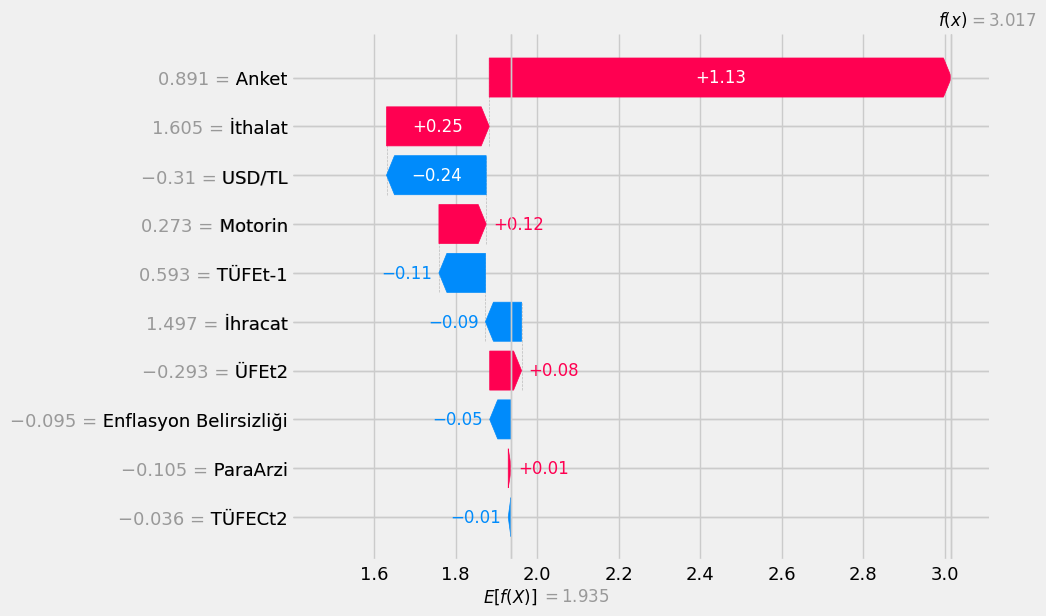

In [53]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


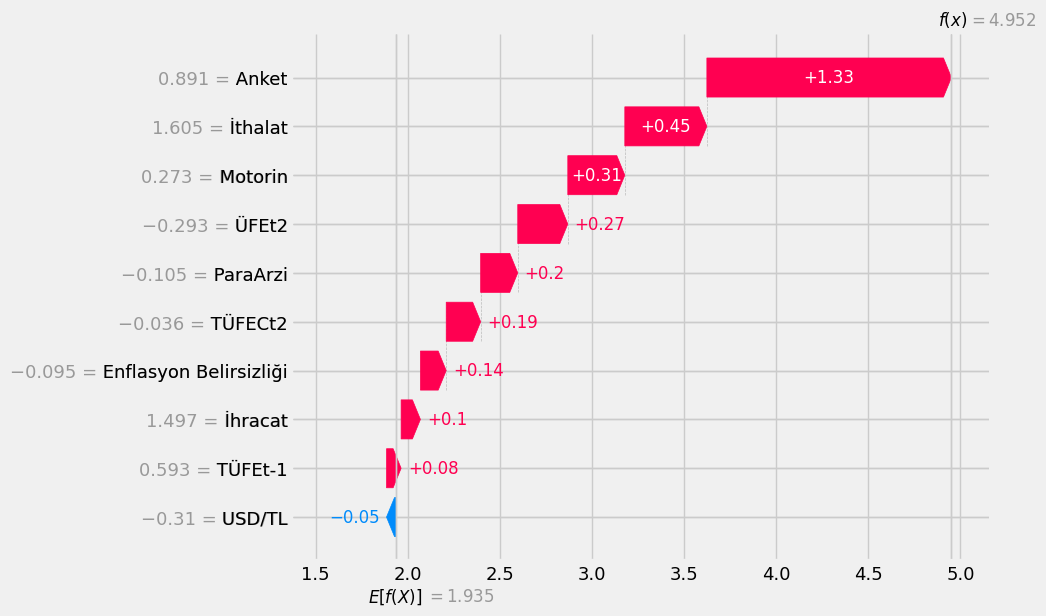

In [54]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (1.935 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    ),max_display=20
)


In [ ]:
shap_values_rescaled = shap_values_reshaped * scaler2.scale_[0]

In [55]:
features=['Motorin','USD/TL', 'M3', 'Enflasyon Belirsizliği', 'Anket','Kredi', 'ÜFEt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=115,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.08154264548540417)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.023117556598032486)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=7,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler.columns=["TÜFE"]
tahminler["NN1"]=scaler2.inverse_transform(y_pred)
tahminler=tahminler.set_index(data.index[-7:])

Epoch 1/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 1.6775 - mean_squared_error: 0.8838 - val_loss: 1.3340 - val_mean_squared_error: 0.9004
Epoch 2/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6998 - mean_squared_error: 0.3245 - val_loss: 0.4425 - val_mean_squared_error: 0.2297
Epoch 3/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4496 - mean_squared_error: 0.2672 - val_loss: 0.2854 - val_mean_squared_error: 0.1716
Epoch 4/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4100 - mean_squared_error: 0.3107 - val_loss: 0.2501 - val_mean_squared_error: 0.1450
Epoch 5/1000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3920 - mean_squared_error: 0.2970 - val_loss: 0.3025 - val_mean_squared_error: 0.2279
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [56]:
mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["NN1"].iloc[:-1])

0.21466442930261323

In [57]:
tahminler

,TÜFE,NN1
2024-02-29,4.529188,3.976447
2024-03-31,3.162671,3.452077
2024-04-30,3.179759,3.104345
2024-05-31,3.368063,2.742103
2024-06-30,1.640774,2.228262
2024-07-31,3.225556,2.830523
2024-08-31,0.000000,2.730487


In [ ]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


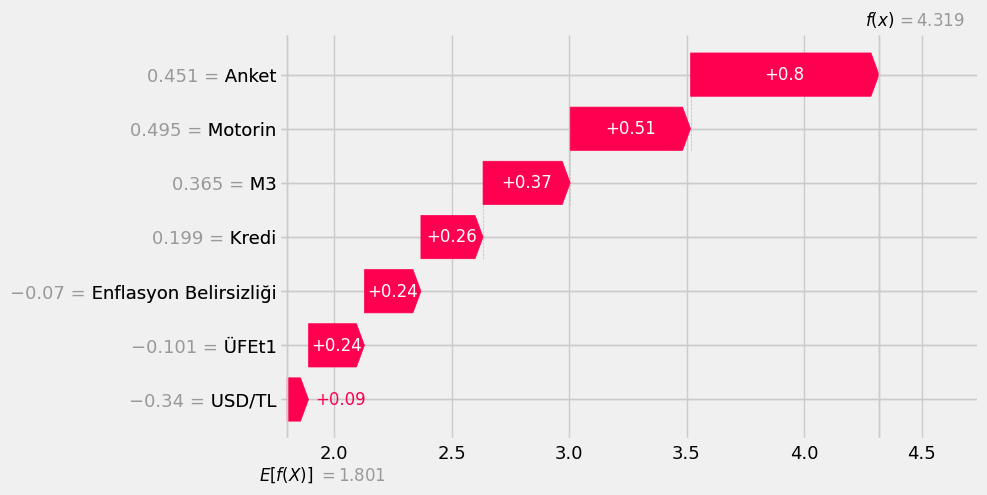

In [ ]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (1.801 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
study.best_params

{'learning_rate': 0.0032753771994387506,
 'units1': 167,
 'batch_size': 49,
 'activation1': 'selu',
 'optimizer': 'adam',
 'rlrate': 0.8578521656956516}

In [58]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi','İhracat','Anket',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=167,activation="selu",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.8578521656956516)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0032753771994387506)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=49,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler2=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler2.columns=["TÜFE"]
tahminler2["NN2"]=scaler2.inverse_transform(y_pred)
tahminler2=tahminler2.set_index(data.index[-7:])

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 21.0994 - mean_squared_error: 2.5421 - val_loss: 17.6766 - val_mean_squared_error: 0.6847
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 17.2136 - mean_squared_error: 0.5307 - val_loss: 15.1569 - val_mean_squared_error: 0.2953
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 14.9917 - mean_squared_error: 0.4383 - val_loss: 13.0330 - val_mean_squared_error: 0.2388
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 12.8832 - mean_squared_error: 0.3739 - val_loss: 11.1577 - val_mean_squared_error: 0.2586
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 10.9263 - mean_squared_error: 0.2842 - val_loss: 9.5629 - val_mean_squared_error: 0.3644
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.2861 - mean_squared_error: 0.3155 - val_loss: 8.1346 - val_mean_squared_error: 0.4379
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 7.8643 - mean_squared_error: 0.3668 - val_loss: 6

In [59]:
mean_squared_error(tahminler2["TÜFE"].iloc[:-1],tahminler2["NN2"].iloc[:-1])

0.08103812493362207

In [60]:
tahminler2

,TÜFE,NN2
2024-02-29,4.529188,4.724082
2024-03-31,3.162671,3.462475
2024-04-30,3.179759,3.071234
2024-05-31,3.368063,2.952925
2024-06-30,1.640774,1.775344
2024-07-31,3.225556,2.830416
2024-08-31,0.000000,2.664193


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 107 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 14%|█▍        | 1/7 [00:12<01:17, 12.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 6s 880us/step


 29%|██▊       | 2/7 [00:23<00:56, 11.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 6s 882us/step


 43%|████▎     | 3/7 [00:33<00:43, 10.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 57%|█████▋    | 4/7 [00:45<00:33, 11.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 71%|███████▏  | 5/7 [00:56<00:22, 11.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 962us/step


 86%|████████▌ | 6/7 [01:07<00:11, 11.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


100%|██████████| 7/7 [01:19<00:00, 11.31s/it]


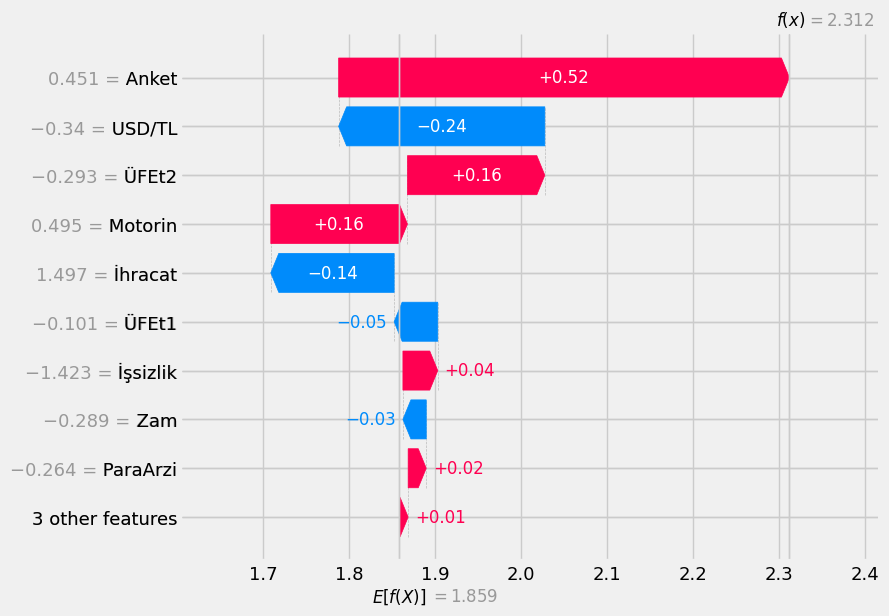

In [ ]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


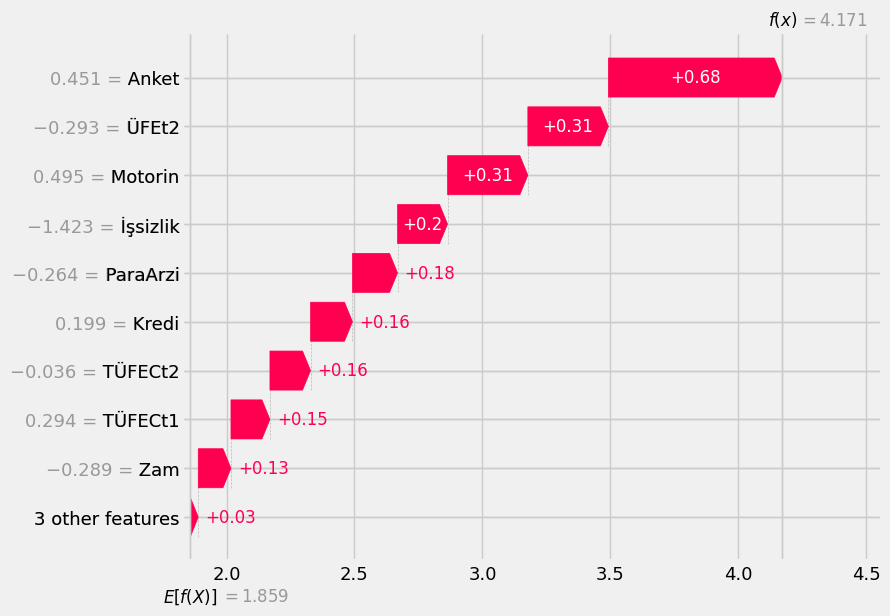

In [ ]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (1.859 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


In [ ]:
study.best_params

{'learning_rate': 0.006018245014889451,
 'units1': 67,
 'batch_size': 3,
 'activation1': 'tanh',
 'optimizer': 'adam',
 'rlrate': 0.0661993224622172}

In [61]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket','İhracat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-13,:],X.iloc[-13:,:]
y_train,y_test=y[:-13],y[-13:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=67,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.0661993224622172)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.006018245014889451)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=3,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler3=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler3.columns=["TÜFE"]
tahminler3["NN3"]=scaler2.inverse_transform(y_pred)
tahminler3=tahminler3.set_index(data.index[-13:])


Epoch 1/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.7505 - mean_squared_error: 0.6190 - val_loss: 0.9090 - val_mean_squared_error: 0.1801
Epoch 2/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9266 - mean_squared_error: 0.2821 - val_loss: 0.5320 - val_mean_squared_error: 0.0854
Epoch 3/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5890 - mean_squared_error: 0.1872 - val_loss: 0.3602 - val_mean_squared_error: 0.0677
Epoch 4/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4190 - mean_squared_error: 0.1533 - val_loss: 0.2775 - val_mean_squared_error: 0.0733
Epoch 5/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3435 - mean_squared_error: 0.1553 - val_loss: 0.2332 - val_mean_squared_error: 0.0831
Epoch 6/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2859 - mean_squared_error: 0.1456 - val_loss: 0.2008 - val_mean_squared_error: 0.0817
Epoch 7/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2568 - mean_squared_error: 0.1445 - val_loss: 0.1

In [62]:
tahminler3

,TÜFE,NN3
2023-08-31,9.086793,9.341813
2023-09-30,4.753114,5.261580
2023-10-31,3.433981,3.016394
2023-11-30,3.281097,3.271423
2023-12-31,2.927207,3.062819
2024-01-31,6.703310,6.892769
2024-02-29,4.529188,4.609038
2024-03-31,3.162671,3.104861
2024-04-30,3.179759,2.911197
2024-05-31,3.368063,2.852943


In [63]:
mean_squared_error(tahminler3["TÜFE"].iloc[:-1],tahminler3["NN3"].iloc[:-1])

0.07581394984058375

In [ ]:
study.best_params

{'learning_rate': 0.007869572470532615,
 'units1': 30,
 'batch_size': 32,
 'activation1': 'tanh',
 'optimizer': 'adam',
 'rlrate': 0.0648134949904951}

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 101 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/13 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


  8%|▊         | 1/13 [00:12<02:31, 12.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 15%|█▌        | 2/13 [00:23<02:06, 11.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 23%|██▎       | 3/13 [00:35<01:59, 11.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 31%|███       | 4/13 [00:48<01:50, 12.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 38%|███▊      | 5/13 [01:01<01:39, 12.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 46%|████▌     | 6/13 [01:14<01:29, 12.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 54%|█████▍    | 7/13 [01:27<01:16, 12.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 62%|██████▏   | 8/13 [01:40<01:04, 12.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 69%|██████▉   | 9/13 [01:51<00:49, 12.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 6s 863us/step


 77%|███████▋  | 10/13 [02:01<00:34, 11.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 85%|████████▍ | 11/13 [02:12<00:22, 11.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 6s 949us/step


 92%|█████████▏| 12/13 [02:22<00:10, 10.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6540/6540 ━━━━━━━━━━━━━━━━━━━━ 6s 911us/step


100%|██████████| 13/13 [02:32<00:00, 11.71s/it]


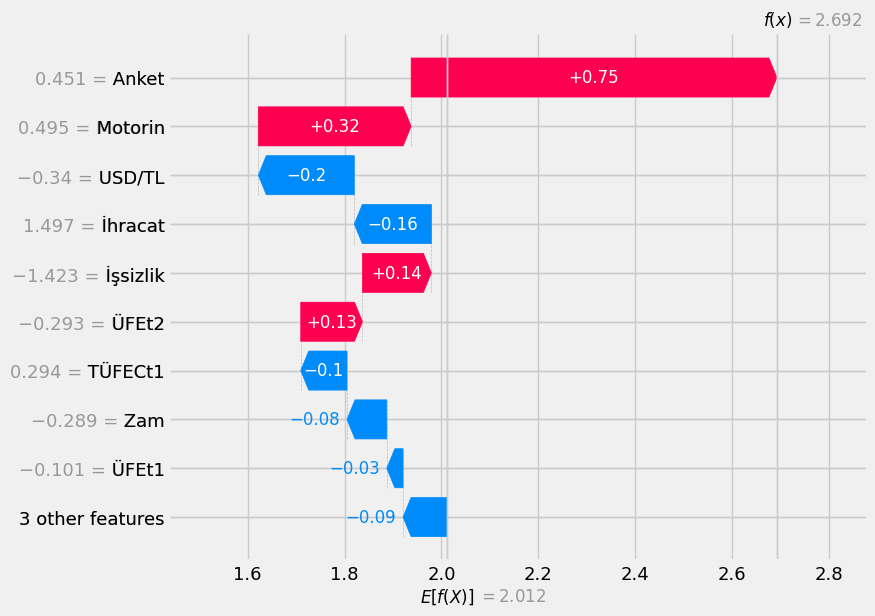

In [ ]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


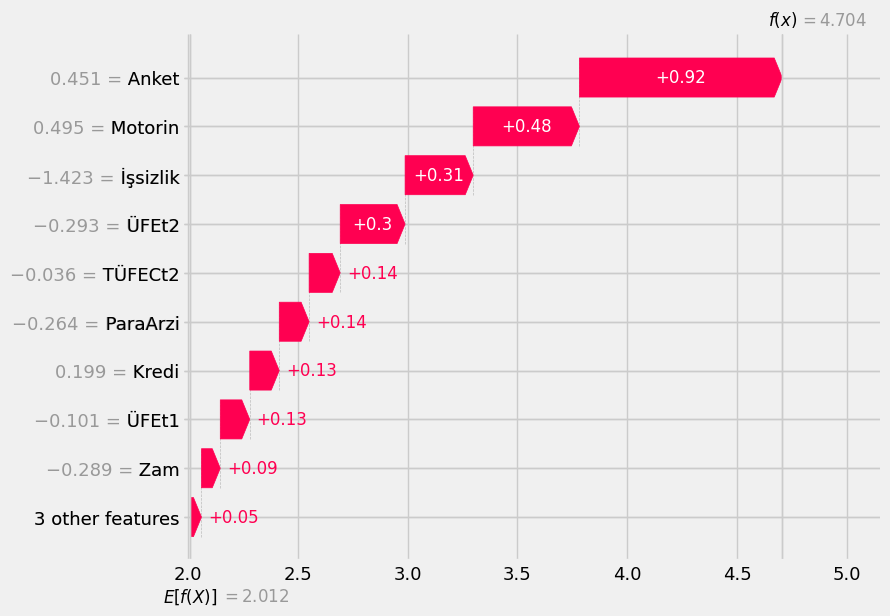

In [ ]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (2.012 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


In [64]:
features=['USD/TL','Motorin','Anket','Enflasyon Belirsizliği','ÜFEt1','ParaArzi','TÜFEt-1','TÜFECt1','Zam','Kredi','ÜFEt2','TÜFECt2' ,'TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=30,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.0648134949904951)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.007869572470532615)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=32,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler4=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler4.columns=["TÜFE"]
tahminler4["NN4"]=scaler2.inverse_transform(y_pred)
tahminler4=tahminler4.set_index(data.index[-7:])

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 3.0153 - mean_squared_error: 1.9383 - val_loss: 1.8063 - val_mean_squared_error: 0.7838
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6445 - mean_squared_error: 0.6366 - val_loss: 1.4212 - val_mean_squared_error: 0.4794
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6022 - mean_squared_error: 0.6782 - val_loss: 1.1819 - val_mean_squared_error: 0.3310
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3372 - mean_squared_error: 0.5034 - val_loss: 1.0006 - val_mean_squared_error: 0.2352
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.0754 - mean_squared_error: 0.3254 - val_loss: 0.9799 - val_mean_squared_error: 0.2916
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9919 - mean_squared_error: 0.3177 - val_loss: 0.9023 - val_mean_squared_error: 0.2841
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8875 - mean_squared_error: 0.2820 - val_loss: 0.7463 - va

In [65]:
tahminler4

,TÜFE,NN4
2024-02-29,4.529188,4.595925
2024-03-31,3.162671,3.574981
2024-04-30,3.179759,3.372934
2024-05-31,3.368063,2.960501
2024-06-30,1.640774,1.807138
2024-07-31,3.225556,3.058854
2024-08-31,0.000000,2.783091


In [66]:
mean_squared_error(tahminler4["TÜFE"].iloc[:-1],tahminler4["NN4"].iloc[:-1])

0.07222377408695205

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 107 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 14%|█▍        | 1/7 [00:12<01:14, 12.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 29%|██▊       | 2/7 [00:26<01:06, 13.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 43%|████▎     | 3/7 [00:39<00:52, 13.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 999us/step


 57%|█████▋    | 4/7 [00:50<00:37, 12.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 71%|███████▏  | 5/7 [01:03<00:25, 12.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 86%|████████▌ | 6/7 [01:16<00:12, 12.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


100%|██████████| 7/7 [01:28<00:00, 12.58s/it]


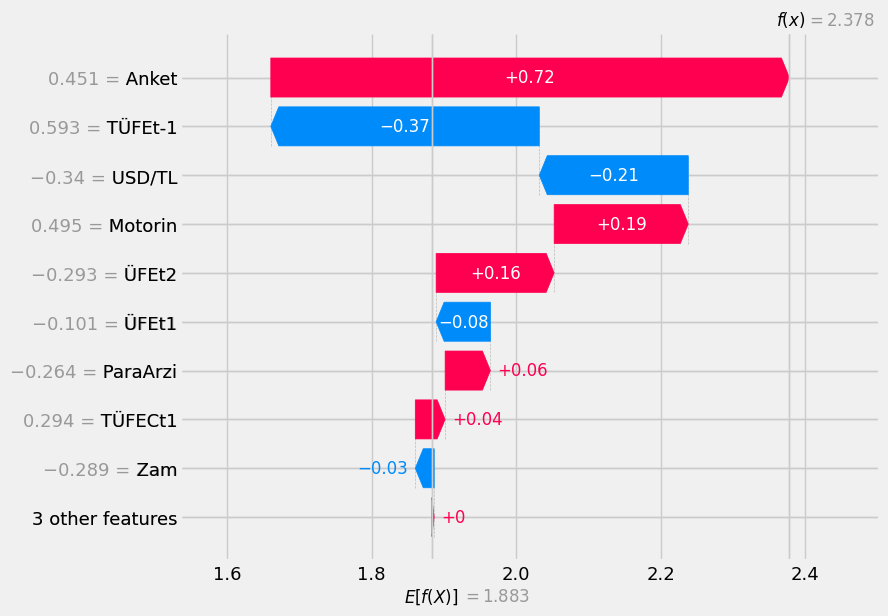

In [ ]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


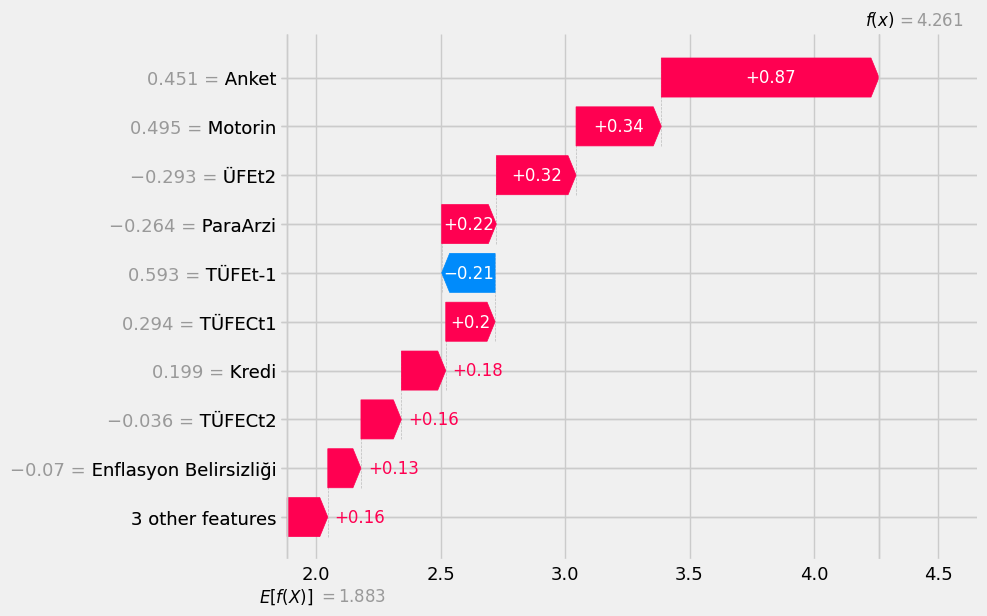

In [ ]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (1.883 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


In [67]:
features=['USD/TL', 'Motorin', 'Zam', 'ParaArzi', 'Kredi', 'Anket',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-14,:],X.iloc[-14:,:]
y_train,y_test=y[:-14],y[-14:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=5,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.8310286967708689)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.010246301807480833)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=5000, batch_size=15,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler5=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler5.columns=["TÜFE"]
tahminler5["NN5"]=scaler2.inverse_transform(y_pred)
tahminler5=tahminler5.set_index(data.index[-14:])

Epoch 1/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 8.7617 - mean_squared_error: 2.9532 - val_loss: 5.5950 - val_mean_squared_error: 0.8373
Epoch 2/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.4582 - mean_squared_error: 2.0009 - val_loss: 3.7965 - val_mean_squared_error: 0.2781
Epoch 3/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7129 - mean_squared_error: 1.4395 - val_loss: 2.6255 - val_mean_squared_error: 0.1070
Epoch 4/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.3552 - mean_squared_error: 1.0308 - val_loss: 1.7995 - val_mean_squared_error: 0.0651
Epoch 5/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4118 - mean_squared_error: 0.8248 - val_loss: 1.1997 - val_mean_squared_error: 0.0529
Epoch 6/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7328 - mean_squared_error: 0.6900 - val_loss: 0.7933 - val_mean_squared_error: 0.0560
Epoch 7/5000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2590 - mean_squared_error: 0.5899 - val_loss: 0.5267 - val_mea

In [68]:
mean_squared_error(tahminler5["TÜFE"].iloc[:-1],tahminler5["NN5"].iloc[:-1])

0.13008307051514045

In [69]:
tahminler5

,TÜFE,NN5
2023-07-31,9.488824,9.169553
2023-08-31,9.086793,9.076726
2023-09-30,4.753114,5.328982
2023-10-31,3.433981,3.163080
2023-11-30,3.281097,3.143733
2023-12-31,2.927207,2.867727
2024-01-31,6.703310,6.224517
2024-02-29,4.529188,4.234111
2024-03-31,3.162671,3.291318
2024-04-30,3.179759,2.988591


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  0%|          | 0/14 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


  7%|▋         | 1/14 [00:13<02:57, 13.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 14%|█▍        | 2/14 [00:26<02:41, 13.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 21%|██▏       | 3/14 [00:39<02:21, 12.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 29%|██▊       | 4/14 [00:51<02:05, 12.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 6s 999us/step


 36%|███▌      | 5/14 [01:02<01:48, 12.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 43%|████▎     | 6/14 [01:14<01:36, 12.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 50%|█████     | 7/14 [01:26<01:25, 12.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 6s 949us/step


 57%|█████▋    | 8/14 [01:37<01:09, 11.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 6s 923us/step


 64%|██████▍   | 9/14 [01:46<00:54, 10.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 71%|███████▏  | 10/14 [01:58<00:44, 11.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 79%|███████▊  | 11/14 [02:09<00:33, 11.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 86%|████████▌ | 12/14 [02:20<00:22, 11.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 6s 898us/step


 93%|█████████▎| 13/14 [02:30<00:10, 10.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6394/6394 ━━━━━━━━━━━━━━━━━━━━ 6s 891us/step


100%|██████████| 14/14 [02:39<00:00, 11.41s/it]


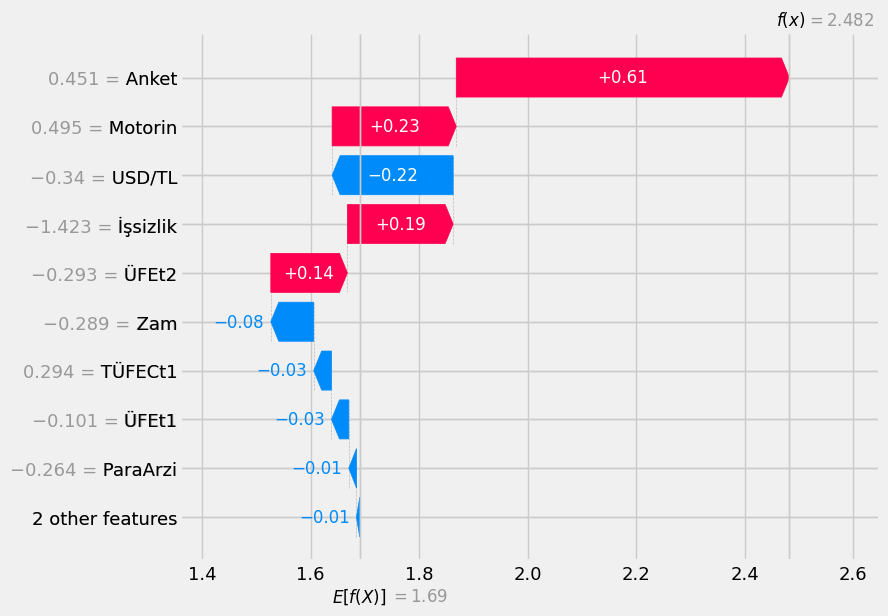

In [ ]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


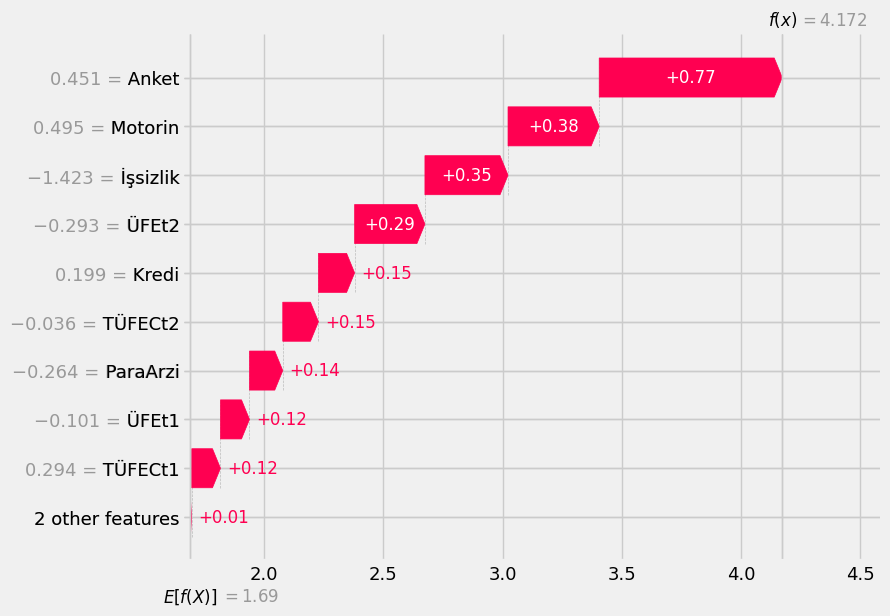

In [ ]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (1.69 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


In [ ]:
study.best_params

{'learning_rate': 0.0004324233099094171,
 'units1': 143,
 'batch_size': 30,
 'activation1': 'linear',
 'optimizer': 'adam',
 'rlrate': 0.1679762527788078}

In [70]:
features=['Anket','Enflasyon Belirsizliği','ÜFEt1','ParaArzi','USD/TL','Motorin','TÜFEt-1','TÜFECt1','Kredi','ÜFEt2','Zam','TÜFECt2','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=143,activation="linear",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.1679762527788078)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0004324233099094171)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=1000, batch_size=30,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler6=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler6.columns=["TÜFE"]
tahminler6["NN6"]=scaler2.inverse_transform(y_pred)
tahminler6=tahminler6.set_index(data.index[-7:])

Epoch 1/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 4.1744 - mean_squared_error: 0.5938 - val_loss: 4.4203 - val_mean_squared_error: 0.8638
Epoch 2/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.9233 - mean_squared_error: 0.3748 - val_loss: 4.1324 - val_mean_squared_error: 0.6167
Epoch 3/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.7968 - mean_squared_error: 0.2911 - val_loss: 3.9212 - val_mean_squared_error: 0.4561
Epoch 4/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.7246 - mean_squared_error: 0.2711 - val_loss: 3.7645 - val_mean_squared_error: 0.3565
Epoch 5/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.6564 - mean_squared_error: 0.2608 - val_loss: 3.6431 - val_mean_squared_error: 0.2954
Epoch 6/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.5779 - mean_squared_error: 0.2428 - val_loss: 3.5450 - val_mean_squared_error: 0.2585
Epoch 7/1000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.4960 - mean_squared_error: 0.2222 - val_loss: 3.4615 - va

In [71]:
tahminler6

,TÜFE,NN6
2024-02-29,4.529188,4.512932
2024-03-31,3.162671,3.672600
2024-04-30,3.179759,3.348935
2024-05-31,3.368063,2.859635
2024-06-30,1.640774,1.683059
2024-07-31,3.225556,3.129369
2024-08-31,0.000000,2.821910


In [72]:
mean_squared_error(tahminler6["TÜFE"].iloc[:-1],tahminler6["NN6"].iloc[:-1])

0.09307521017304216

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 107 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 14%|█▍        | 1/7 [00:12<01:14, 12.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 6s 929us/step


 29%|██▊       | 2/7 [00:23<00:58, 11.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 43%|████▎     | 3/7 [00:37<00:50, 12.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 57%|█████▋    | 4/7 [00:49<00:37, 12.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


 71%|███████▏  | 5/7 [01:01<00:24, 12.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 6s 914us/step


 86%|████████▌ | 6/7 [01:12<00:11, 11.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
6929/6929 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


100%|██████████| 7/7 [01:24<00:00, 12.08s/it]


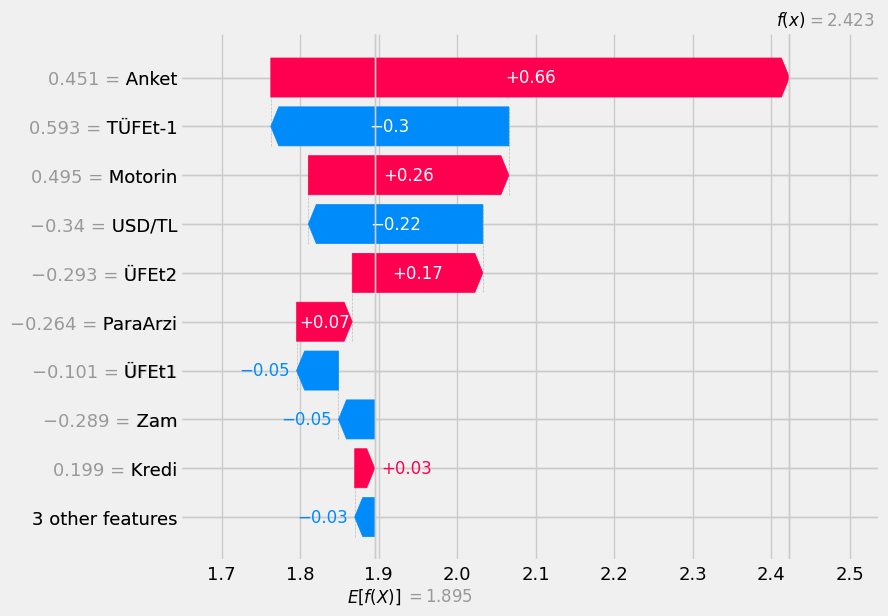

In [ ]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)

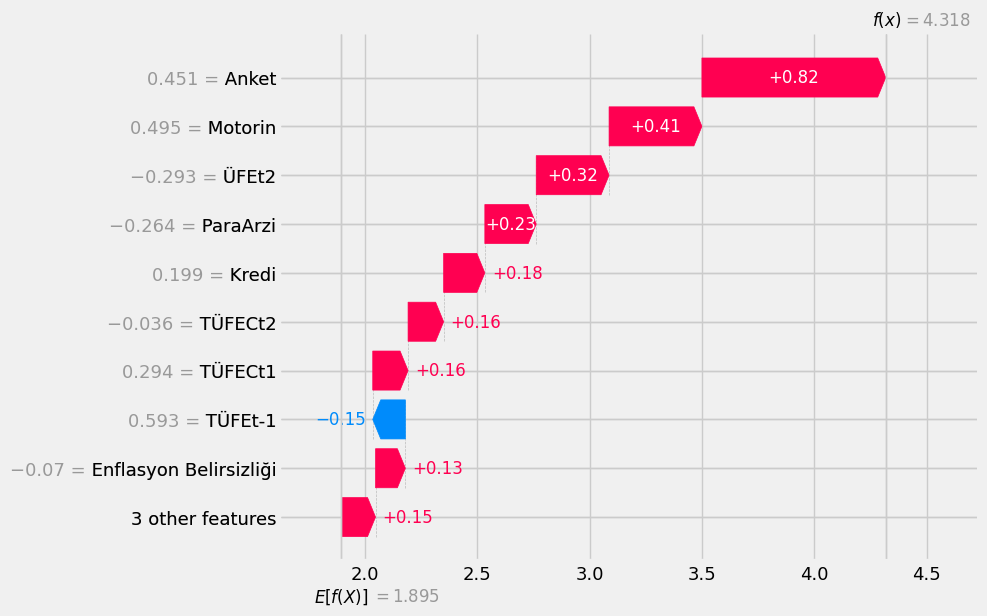

In [ ]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (1.895 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


In [73]:
features=['Anket','Enflasyon Belirsizliği','ÜFEt1','ParaArzi','USD/TL','Motorin','TÜFEt-1','TÜFECt1','Kredi','ÜFEt2','Zam','TÜFE']
data1=data[features]
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
X=scaled_data
X=X.iloc[:,:-1]
y=scaled_data["TÜFE"]
X=np.array(X)
y=np.array(y).reshape(-1,1)
X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
y=pd.DataFrame(y,columns=["TÜFE"])
X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
y_train,y_test=y[:-7],y[-7:]
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
keras.utils.set_random_seed(42)
early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
model = Sequential()   
model.add(Dense(units=25,activation="tanh",input_dim=(X_train.shape[1]),kernel_regularizer=l2(0.9508439168991856)))
model.add(Dense(units=1))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.004681420261569405)
model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
history=model.fit(X_train, y_train, epochs=5000, batch_size=20,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))
y_pred = model.predict(X_test)
tahminler7=pd.DataFrame(scaler2.inverse_transform(y_test))
tahminler7.columns=["TÜFE"]
tahminler7["NN7"]=scaler2.inverse_transform(y_pred)
tahminler7=tahminler7.set_index(data.index[-7:])

Epoch 1/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 14.7544 - mean_squared_error: 0.8658 - val_loss: 13.1315 - val_mean_squared_error: 1.2141
Epoch 2/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.8658 - mean_squared_error: 0.4750 - val_loss: 10.4366 - val_mean_squared_error: 0.7914
Epoch 3/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.5602 - mean_squared_error: 0.3761 - val_loss: 8.2430 - val_mean_squared_error: 0.5745
Epoch 4/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.6059 - mean_squared_error: 0.3286 - val_loss: 6.4795 - val_mean_squared_error: 0.4720
Epoch 5/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.9811 - mean_squared_error: 0.2945 - val_loss: 5.0709 - val_mean_squared_error: 0.4151
Epoch 6/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.6672 - mean_squared_error: 0.2681 - val_loss: 3.9232 - val_mean_squared_error: 0.3437
Epoch 7/5000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6174 - mean_squared_error: 0.2404 - val_loss: 3.0018 

In [74]:
tahminler7

,TÜFE,NN7
2024-02-29,4.529188,4.330486
2024-03-31,3.162671,3.545410
2024-04-30,3.179759,3.266653
2024-05-31,3.368063,2.749370
2024-06-30,1.640774,1.651479
2024-07-31,3.225556,3.036067
2024-08-31,0.000000,2.695646


In [75]:
mean_squared_error(tahminler7["TÜFE"].iloc[:-1],tahminler7["NN7"].iloc[:-1])

0.10205415320042881

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Using 107 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step


 14%|█▍        | 1/7 [00:13<01:22, 13.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 29%|██▊       | 2/7 [00:25<01:04, 12.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 43%|████▎     | 3/7 [00:38<00:51, 12.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 57%|█████▋    | 4/7 [00:52<00:39, 13.04s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 7s 984us/step


 71%|███████▏  | 5/7 [01:04<00:25, 12.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step


 86%|████████▌ | 6/7 [01:16<00:12, 12.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
6842/6842 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


100%|██████████| 7/7 [01:27<00:00, 12.57s/it]


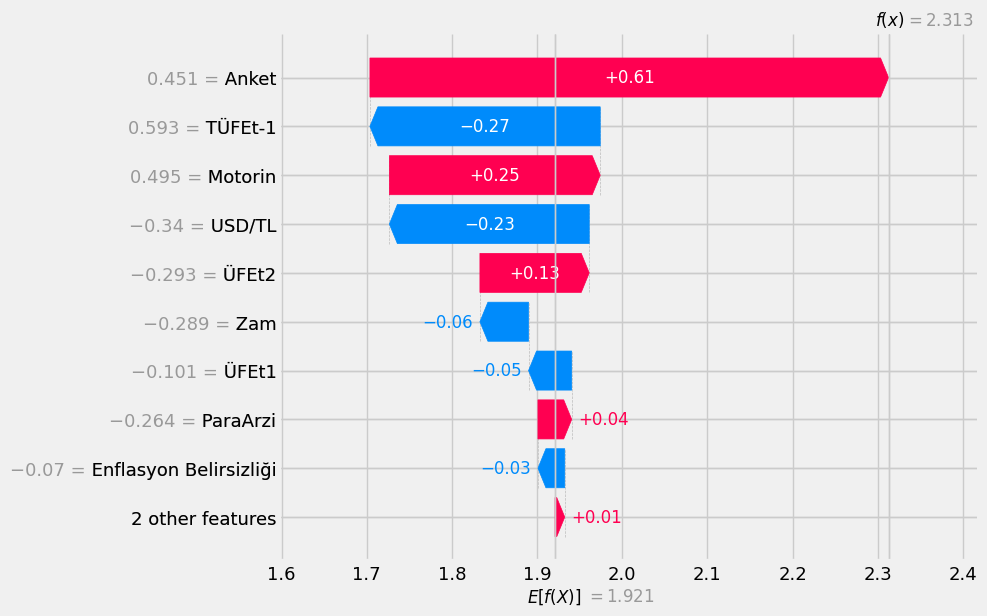

In [ ]:
import shap
explainer = shap.KernelExplainer(model.predict, X_train)
shap_values = explainer.shap_values(X_test)

shap_values_reshaped = shap_values.reshape(shap_values.shape[0], shap_values.shape[1])
shap_values_last_observation = np.array(shap_values_reshaped[-1, :])

expected_value = explainer.expected_value

# SHAP değerlerini tersine ölçeklendirme
shap_values_last_observation_rescaled = shap_values_last_observation * scaler2.scale_[0]

# Baz değeri tersine ölçeklendirme
expected_value_rescaled = expected_value * scaler2.scale_[0] + scaler2.mean_[0]

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_last_observation_rescaled,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)

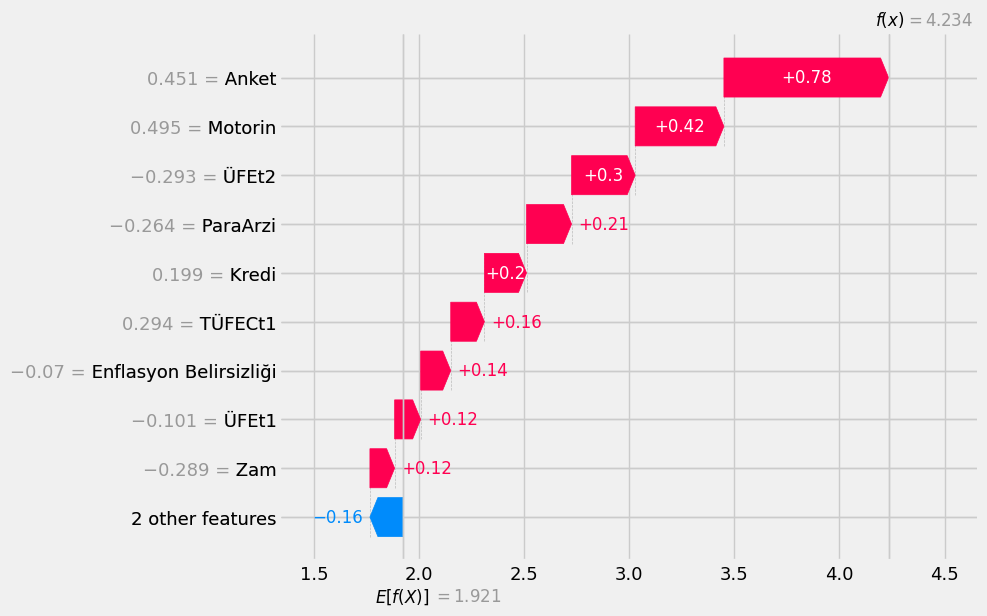

In [ ]:
# Eğer constant değeri hala yüksekse, farkı SHAP değerlerine dağıtın
shap_values_adjusted = shap_values_last_observation_rescaled + (1.921 / len(shap_values_last_observation_rescaled))

# SHAP waterfall plot ile görselleştirme
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_adjusted,
        base_values=expected_value_rescaled,
        data=X_test.iloc[-1, :],
        feature_names=X_test.columns
    )
)


In [76]:
kısatahminler=pd.concat([data["TÜFE"].iloc[-14:],tahminler.iloc[:,1],tahminler2.iloc[:,1],tahminler3.iloc[:,1],tahminler4.iloc[:,1],tahminler5.iloc[:,1],tahminler6.iloc[:,1],tahminler7.iloc[:,1]],axis=1)
kısatahminler["Ortalama"]=kısatahminler.iloc[:,1:].mean(axis=1)
kısatahminler.loc["2024-05-31", ["NN1","NN2","NN3","NN4","NN5","NN6","NN7","Ortalama"]] += 0.66
kısatahminler

,TÜFE,NN1,NN2,NN3,NN4,NN5,NN6,NN7,Ortalama
2023-07-31,9.488824,NaN,NaN,NaN,NaN,9.169553,NaN,NaN,9.169553
2023-08-31,9.086793,NaN,NaN,9.341813,NaN,9.076726,NaN,NaN,9.209270
2023-09-30,4.753114,NaN,NaN,5.261580,NaN,5.328982,NaN,NaN,5.295281
2023-10-31,3.433981,NaN,NaN,3.016394,NaN,3.163080,NaN,NaN,3.089737
2023-11-30,3.281097,NaN,NaN,3.271423,NaN,3.143733,NaN,NaN,3.207578
2023-12-31,2.927207,NaN,NaN,3.062819,NaN,2.867727,NaN,NaN,2.965273
2024-01-31,6.703310,NaN,NaN,6.892769,NaN,6.224517,NaN,NaN,6.558643
2024-02-29,4.529188,3.976447,4.724082,4.609038,4.595925,4.234111,4.512932,4.330486,4.426146
2024-03-31,3.162671,3.452077,3.462475,3.104861,3.574981,3.291318,3.672600,3.545410,3.443389
2024-04-30,3.179759,3.104345,3.071234,2.911197,3.372934,2.988591,3.348935,3.266653,3.151984


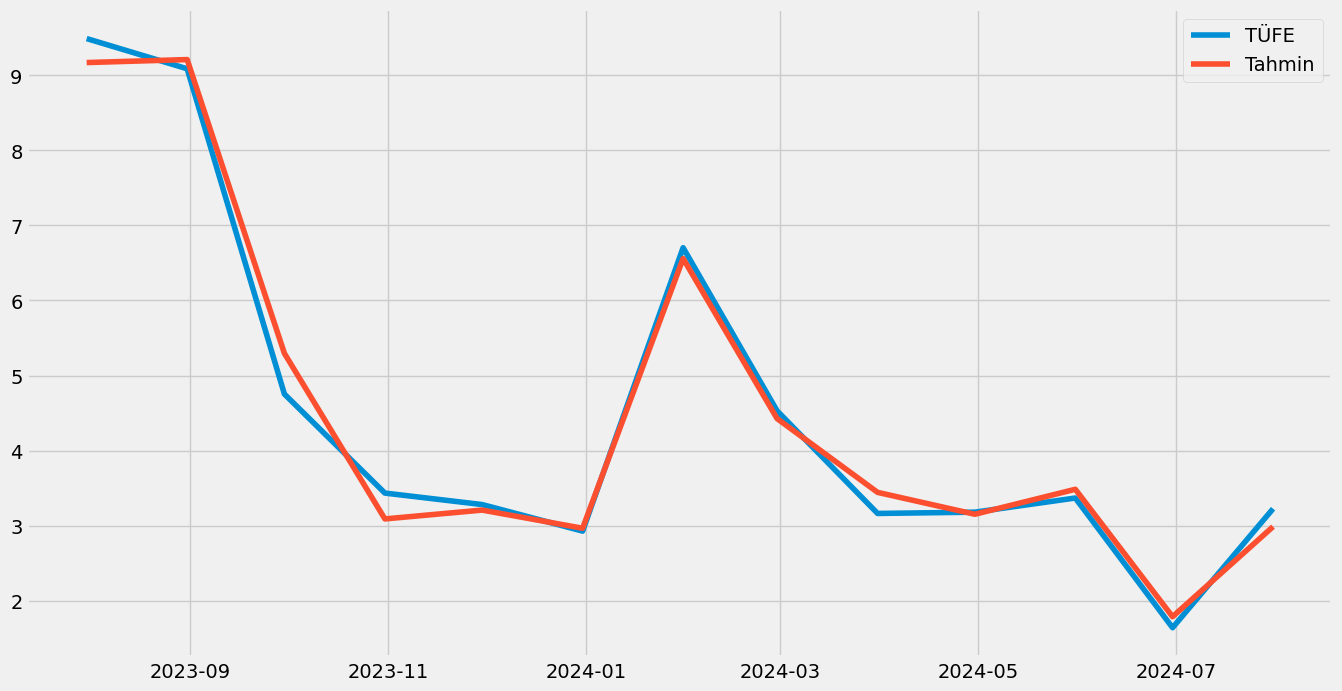

In [77]:
plt.figure(figsize=(15,8))
plt.plot(kısatahminler["TÜFE"].iloc[:-1],label="TÜFE")
plt.plot(kısatahminler["Ortalama"].iloc[:-1],label="Tahmin")
plt.legend()

## Orta Vadeli Tahminler

In [61]:
model=auto_arima(pfaiz["Faiz"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Faiz"])
faiztahmin = model_fit.predict(25)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Faiz"]
row=pd.DataFrame({"Faiz":pfaiz.iloc[-4:,0]},index=pd.date_range(start="2024-05-30",periods=4,freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)

faiztahmin.iloc[4:,0]=[50,50,50,50,50,50,50,50,50,50,50,45,40,35,35,35,35,30,30,30,30,30,25,25,25]
faiztahmin

,Faiz
2024-05-31,50.544545
2024-06-30,50.106471
2024-07-31,50.000000
2024-08-31,50.307143
2024-09-30,50.000000
2024-10-31,50.000000
2024-11-30,50.000000
2024-12-31,50.000000
2025-01-31,50.000000
2025-02-28,50.000000


In [62]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [63]:
exog=pd.DataFrame()
exog["X"]=usd["USD/TL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,98.018605
2007-08-31,92.575734
2007-10-31,96.717890
2007-11-30,108.097970
2007-12-31,106.272939
...,...
2024-01-31,2403.768371
2024-02-29,2544.817510
2024-04-30,2888.099783
2024-05-31,2676.648082


In [64]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,0,0,0,0,49.11,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,25]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-02-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0.00
2023-09-30,0.00
2023-10-31,0.00
2023-11-30,0.00
2023-12-31,0.00
2024-01-31,49.11
2024-02-29,0.00
2024-03-31,0.00
2024-04-30,0.00
2024-05-31,0.00


In [65]:
faiztahmin.columns=["Faiz"]


In [66]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Faiz"].iloc[95:-13]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Faiz"].iloc[-14:-3],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [67]:
exog=pfaiz["Faiz"].iloc[36:-2]
exog=np.array(exog).reshape(-1,1)

In [68]:
exogtest=faiztahmin.iloc[2:]
exogtest=np.array(exogtest).reshape(-1,1)

In [69]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(27,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2024-07-31,9.209575
2024-08-31,9.166522
2024-09-30,9.302068
2024-10-31,9.303669
2024-11-30,9.296117
2024-12-31,9.321257
2025-01-31,9.321562
2025-02-28,9.320126
2025-03-31,9.324906
2025-04-30,9.324964


In [70]:
from prophet import Prophet

In [ ]:
import optuna


In [ ]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.01, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.50,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"])

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=usd.index
    sn["y"]=usd.values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=500,freq="D")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(usd.values,predictions["yhat"][:-500])
    return mae_score
try:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=1000)
    print("Optimize işlemi başarıyla tamamlandı.")
except Exception as e:
    print(f'Hata oluştu: {e}')
    print('Optimize işlemi başarısız oldu. Devam ediyor...')
"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.01, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.50,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"])\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=usd.index\n    sn["y"]=usd.values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],sea

In [ ]:
"""study.best_params"""

'study.best_params'

In [71]:
sn=pd.DataFrame()
sn["ds"]=usd.index
sn["y"]=usd.values
prophet=Prophet(growth="linear",changepoint_prior_scale=8.828175414699565,changepoint_range=0.950080828826867,seasonality_prior_scale=7.816953755754968,n_changepoints=100,interval_width=0.70,yearly_seasonality=False,weekly_seasonality="auto")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=500,freq="D")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

15:27:46 - cmdstanpy - INFO - Chain [1] start processing
15:27:59 - cmdstanpy - INFO - Chain [1] done processing


In [115]:
(predictions["yhat"].resample('M').mean().tail(18).pct_change()*100).dropna()

ds
2024-09-30    1.598452
2024-10-31    1.622987
2024-11-30    1.604728
2024-12-31    1.574386
2025-01-31    1.573526
2025-02-28    1.479405
2025-03-31    1.458473
2025-04-30    1.478527
2025-05-31    1.463480
2025-06-30    1.440960
2025-07-31    1.416710
2025-08-31    1.428442
2025-09-30    1.375698
2025-10-31    1.361009
2025-11-30    1.349349
2025-12-31    1.319521
2026-01-31    0.688824
Freq: ME, Name: yhat, dtype: float64

In [72]:
usdtahmin=(predictions["yhat"].resample('M').mean().tail(18).pct_change()*100).dropna()
usdtahmin

ds
2024-09-30    1.653450
2024-10-31    1.699084
2024-11-30    1.671950
2024-12-31    1.642066
2025-01-31    1.644400
2025-02-28    1.538126
2025-03-31    1.515232
2025-04-30    1.542816
2025-05-31    1.520698
2025-06-30    1.496204
2025-07-31    1.474775
2025-08-31    1.478457
2025-09-30    1.430722
2025-10-31    1.413267
2025-11-30    1.392508
2025-12-31    1.372157
2026-01-31    0.761088
Freq: ME, Name: yhat, dtype: float64

In [73]:
usd_aylık=usd.resample('M').mean().dropna()

In [74]:
usdtahmin1 = []
result = usd_aylık.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([usd_aylık["USD/TL"].loc["2024-03-31":],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2024-03-31", periods=len(usdtahmin1), freq="1M"))
usdtahmin1

,USD/TL
2024-03-31,32.041789
2024-04-30,32.352372
2024-05-31,32.250925
2024-06-30,32.568640
2024-07-31,32.902141
2024-08-31,33.514602
2024-09-30,34.068749
2024-10-31,34.647606
2024-11-30,35.226896
2024-12-31,35.805345


In [ ]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'growth':trial.suggest_categorical('growth',['linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[50:].index
    sn["y"]=df14[50:].values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[50:].index\n    sn["y"]=df14[50:].values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = optuna.create_study(direction=

In [ ]:
"""study.best_params"""

'study.best_params'

In [75]:
sn=pd.DataFrame()
sn["ds"]=df14.index
sn["y"]=df14.values
prophet=Prophet(growth="linear",changepoint_prior_scale=9.333547662504625,changepoint_range=0.9362159367416,seasonality_prior_scale=2.378940289163559,n_changepoints=98)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

15:28:01 - cmdstanpy - INFO - Chain [1] start processing
15:28:02 - cmdstanpy - INFO - Chain [1] done processing


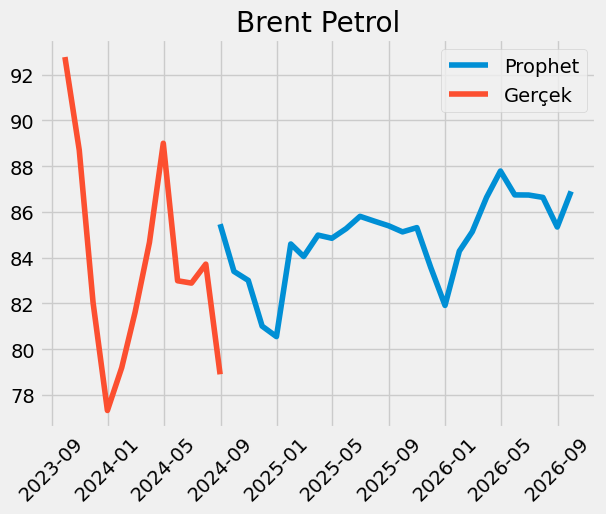

In [160]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-26:],label="Prophet")
plt.plot(df14["Brent"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [76]:
brenttahmin=predictions["yhat"][-29:]
brenttahmin

ds
2024-05-31    83.551065
2024-06-30    84.756073
2024-07-31    84.486358
2024-08-31    85.139579
2024-09-30    83.339194
2024-10-31    82.782615
2024-11-30    80.240648
2024-12-31    79.896478
2025-01-31    84.030733
2025-02-28    83.635793
2025-03-31    84.582616
2025-04-30    84.419612
2025-05-31    84.836722
2025-06-30    85.416611
2025-07-31    85.229714
2025-08-31    84.827465
2025-09-30    84.614187
2025-10-31    84.665183
2025-11-30    82.687581
2025-12-31    81.059912
2026-01-31    83.472868
2026-02-28    84.242281
2026-03-31    85.849324
2026-04-30    87.153134
2026-05-31    86.088205
2026-06-30    86.053877
2026-07-31    85.957350
2026-08-31    84.529712
2026-09-30    85.930852
Name: yhat, dtype: float64

In [ ]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'growth':trial.suggest_categorical('growth',['linear'])

            

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik.index
    sn["y"]=enf_belirsizlik.values
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'growth\':trial.suggest_categorical(\'growth\',[\'linear\'])\n\n            \n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik.index\n    sn["y"]=enf_belirsizlik.values\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=13,freq="M")\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])\n    return mae_score\nstudy = o

15:28:02 - cmdstanpy - INFO - Chain [1] start processing
15:28:02 - cmdstanpy - INFO - Chain [1] done processing


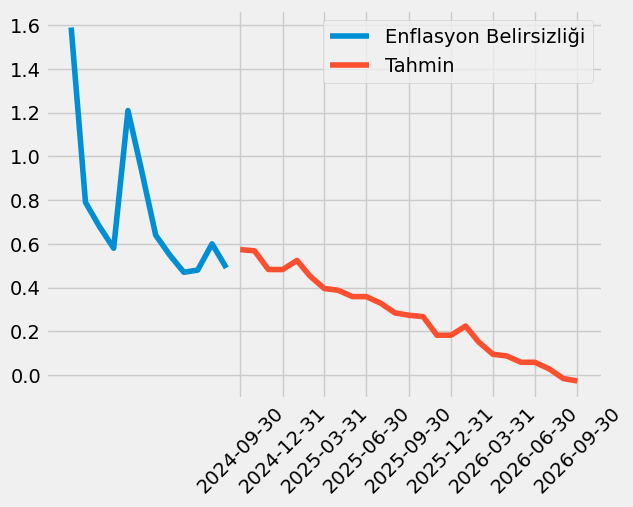

In [77]:
sn=pd.DataFrame()
sn["ds"]=enf_belirsizlik.index
sn["y"]=enf_belirsizlik.values
prophet=Prophet(changepoint_prior_scale=5,changepoint_range=0.85,seasonality_prior_scale=0.0053403857042852,n_changepoints=4,growth="linear")
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])
plt.plot(enf_belirsizlik[-12:],label="Enflasyon Belirsizliği")
plt.plot(predictions["yhat"][-25:],label="Tahmin")
plt.xticks(predictions.index[-25::3],rotation=45)
plt.legend()

In [78]:
enfbelirsizliktahmin1=pd.DataFrame(predictions["yhat"][-26:])
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
enfbelirsizliktahmin1.index.names=[""]
enfbelirsizliktahmin1.iloc[0,0]=enf_belirsizlik.iloc[-1,0]
enfbelirsizliktahmin1

,Enflasyon Belirsizliği
,
2024-08-31,0.490000
2024-09-30,0.573990
2024-10-31,0.568020
2024-11-30,0.482672
2024-12-31,0.482448
2025-01-31,0.524270
2025-02-28,0.452940
2025-03-31,0.395836
2025-04-30,0.387650


In [ ]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',[0.01,10]),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],predictions["yhat"].tail(12))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',[0.01,10]),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][p

In [ ]:
#study.best_params

In [79]:
brenttahmin1=(brenttahmin.pct_change()*100).dropna()
brenttahmin1

ds
2024-06-30    1.442242
2024-07-31   -0.318226
2024-08-31    0.773168
2024-09-30   -2.114628
2024-10-31   -0.667848
2024-11-30   -3.070653
2024-12-31   -0.428922
2025-01-31    5.174514
2025-02-28   -0.469994
2025-03-31    1.132079
2025-04-30   -0.192716
2025-05-31    0.494091
2025-06-30    0.683535
2025-07-31   -0.218807
2025-08-31   -0.471959
2025-09-30   -0.251426
2025-10-31    0.060269
2025-11-30   -2.335792
2025-12-31   -1.968456
2026-01-31    2.976756
2026-02-28    0.921751
2026-03-31    1.907644
2026-04-30    1.518719
2026-05-31   -1.221905
2026-06-30   -0.039875
2026-07-31   -0.112170
2026-08-31   -1.660869
2026-09-30    1.657572
Name: yhat, dtype: float64

In [124]:
(usdtahmin1[:-5].pct_change(periods=1)*100).dropna()

,USD/TL
2024-04-30,1.071456
2024-05-31,-0.252354
2024-06-30,0.847663
2024-07-31,1.147743
2024-08-31,1.718864
2024-09-30,1.598452
2024-10-31,1.622987
2024-11-30,1.604728
2024-12-31,1.574386
2025-01-31,1.573526


In [125]:
(brenttahmin1[:-7]).dropna()

ds
2024-06-30    1.499356
2024-07-31   -0.214644
2024-08-31    0.705268
2024-09-30   -2.210630
2024-10-31   -0.689162
2024-11-30   -3.097721
2024-12-31   -0.407402
2025-01-31    5.158199
2025-02-28   -0.340433
2025-03-31    1.048016
2025-04-30   -0.160871
2025-05-31    0.492727
2025-06-30    0.743324
2025-07-31   -0.171106
2025-08-31   -0.542533
2025-09-30   -0.346817
2025-10-31    0.039564
2025-11-30   -2.331272
2025-12-31   -1.929044
2026-01-31    2.990888
2026-02-28    0.891565
Name: yhat, dtype: float64

In [80]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[:].pct_change(periods=1)*100).dropna())/100)).values*(1+(((brenttahmin1[:-6]).dropna())/100)).values.reshape(-1,1))
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2024-04-28",periods=len(motorintahmin),freq="1M"))
motorintahmin.iloc[0,0]=(motorin.pct_change(periods=1)*100).iloc[-1,0]
motorintahmin[1:]=((motorintahmin[1:])-1)*100
motorintahmin

,Motorin
2024-04-30,9.118859
2024-05-31,-0.630794
2024-06-30,1.765919
2024-07-31,-1.112288
2024-08-31,1.181182
2024-09-30,-1.467974
2024-10-31,1.262874
2024-11-30,6.932979
2024-12-31,1.164354
2025-01-31,2.795095


In [ ]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,100),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"].index
    sn["y"]=money["Para Arzi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["Para Arzi"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,100),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"].index\n    sn["y"]=money["Para Arzi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_rang

In [81]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"].index
sn["y"]=money["Para Arzi"].values
prophet=Prophet(changepoint_prior_scale=0.904897796889,changepoint_range=0.9529543315216538,growth='linear',seasonality_prior_scale=3.03031163229546,n_changepoints=15)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

15:28:03 - cmdstanpy - INFO - Chain [1] start processing
15:28:03 - cmdstanpy - INFO - Chain [1] done processing


In [82]:
paraarzitahmin=(predictions["yhat"]).tail(26)
paraarzitahmin

ds
2024-08-31    1.658140
2024-09-30    3.207179
2024-10-31    3.042485
2024-11-30    2.681702
2024-12-31    2.706094
2025-01-31    1.219761
2025-02-28    1.568144
2025-03-31    3.244222
2025-04-30    2.764160
2025-05-31    2.340793
2025-06-30    2.728782
2025-07-31    1.881079
2025-08-31    1.824900
2025-09-30    2.060032
2025-10-31    1.763197
2025-11-30    1.706385
2025-12-31    2.379926
2026-01-31    0.483284
2026-02-28    1.067472
2026-03-31    2.450574
2026-04-30    1.392508
2026-05-31    1.599527
2026-06-30    2.216642
2026-07-31    0.901866
2026-08-31    1.986162
2026-09-30    0.892163
Name: yhat, dtype: float64

In [83]:
paraarzitahmin1 = paraarzitahmin
paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-09-30", periods=len(paraarzitahmin), freq="1M"))
row=pd.DataFrame({"Para Arzi":money.iloc[-6:,0]},index=pd.date_range(start="2024-03-31",periods=6,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
np.cumprod(1+(paraarzitahmin1.loc["2024-01-31":"2024-12-31"])/100)

,Para Arzi
2024-03-31,1.023967
2024-04-30,1.044264
2024-05-31,1.063682
2024-06-30,1.096729
2024-07-31,1.123738
2024-08-31,1.132211
2024-09-30,1.150984
2024-10-31,1.187898
2024-11-30,1.224040
2024-12-31,1.256865


In [ ]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"][params["m"]:-12].index\n    sn["y"]=borc["Borç

In [ ]:
#study.best_params

In [ ]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,5),
                'n_changepoints':trial.suggest_int('n_changepoints',1,200),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),


                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"].index
    sn["y"]=df3["Kredi"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3.values,predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,5),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,200),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"].index\n    sn["y"]=df3["Kredi"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=

In [ ]:
"""study.best_params"""

'study.best_params'

In [84]:
sn=pd.DataFrame()
sn["ds"]=kredi["Kredi"].index
sn["y"]=kredi["Kredi"].values
prophet=Prophet(changepoint_prior_scale=0.01099759561372614,changepoint_range=0.0589785485153,growth="linear",seasonality_prior_scale=0.04157847860739,n_changepoints=10,yearly_seasonality=True,weekly_seasonality=True)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

15:28:03 - cmdstanpy - INFO - Chain [1] start processing
15:28:03 - cmdstanpy - INFO - Chain [1] done processing


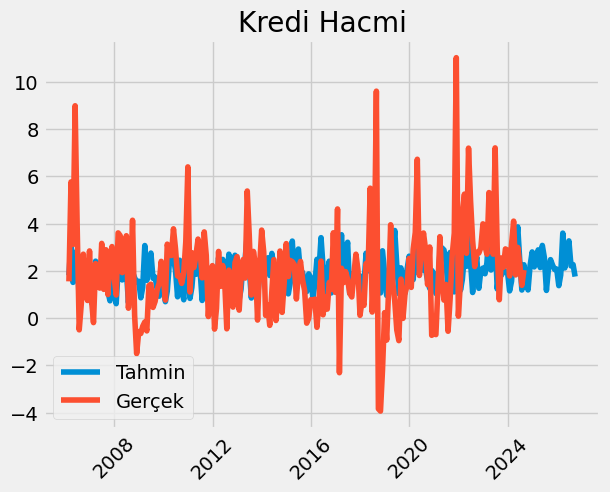

In [111]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(kredi["Kredi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [85]:
kreditahmin=(predictions["yhat"]).tail(26)
kreditahmin

ds
2024-08-31    2.262417
2024-09-30    1.773393
2024-10-31    1.196074
2024-11-30    2.217890
2024-12-31    2.805438
2025-01-31    2.171784
2025-02-28    2.607889
2025-03-31    2.893022
2025-04-30    2.143320
2025-05-31    3.081508
2025-06-30    2.574725
2025-07-31    1.175445
2025-08-31    2.114243
2025-09-30    2.479340
2025-10-31    2.238983
2025-11-30    2.063739
2025-12-31    2.079819
2026-01-31    1.377109
2026-02-28    1.827285
2026-03-31    3.601257
2026-04-30    2.126944
2026-05-31    2.925524
2026-06-30    3.273582
2026-07-31    2.214575
2026-08-31    2.269608
2026-09-30    1.761846
Name: yhat, dtype: float64

In [86]:
kreditahmin1 = kreditahmin

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-09-30", periods=len(kreditahmin1), freq="1M"))
row=pd.DataFrame({"Kredi":kredi.iloc[-4:,0]},index=pd.date_range(start="2024-05-30",periods=4,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

,Kredi
2024-05-31,2.996833
2024-06-30,2.281882
2024-07-31,1.391026
2024-08-31,2.037114
2024-09-30,2.262417
2024-10-31,1.773393
2024-11-30,1.196074
2024-12-31,2.217890
2025-01-31,2.805438
2025-02-28,2.171784


In [ ]:
"""import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,150),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3"].index
    sn["y"]=m3["M3"].values
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(m3["M3"],predictions["yhat"][:-12])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,150),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3"].index\n    sn["y"]=m3["M3"].values\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["

In [87]:
sn=pd.DataFrame()
sn["ds"]=m3["M3"].index
sn["y"]=m3["M3"].values
prophet=Prophet(changepoint_prior_scale=2.5,changepoint_range=0.9,growth='linear',seasonality_prior_scale=4.7636997959024185,n_changepoints=10)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=18,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

15:28:04 - cmdstanpy - INFO - Chain [1] start processing
15:28:04 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
m3tahmin=(predictions["yhat"].tail(18))


m3tahmin1 = np.array(m3tahmin).reshape(-1, 1)
m3tahmin1 = pd.DataFrame(m3tahmin1)
m3tahmin1.columns = ["M3"]
m3tahmin1 = m3tahmin1.set_index(pd.date_range(start="2024-09-30", periods=len(m3tahmin1), freq="1M"))
row=pd.DataFrame({"M3":m3.iloc[-4:,0]},index=pd.date_range(start="2024-05-30",periods=4,freq="1M"))
m3tahmin1=pd.concat([row,m3tahmin1],axis=0)
m3tahmin1

,M3
2024-05-31,3.570039
2024-06-30,2.982820
2024-07-31,3.224181
2024-08-31,3.766257
2024-09-30,3.392391
2024-10-31,3.590129
2024-11-30,3.200993
2024-12-31,2.473580
2025-01-31,1.526155
2025-02-28,2.027448


In [ ]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(cha

In [ ]:
#study.best_params

In [ ]:
"""def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_int('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"].index
    sn["y"]=redkt["REDKT"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"],predictions["yhat"][:-36])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)"""

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_int(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"].index\n    sn["y"]=redkt["REDKT"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scal

In [89]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean()],axis=1)

tahmindf=tahmindf.pct_change(periods=1)*100
tahmindf["M3"]=m3tahmin1["M3"].shift(1)
tahmindf["Para Arzi"]=paraarzitahmin1.rolling(3).mean()
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Kredi"]=kreditahmin1["Kredi"].shift(1).rolling(2).mean()
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"].rolling(2).mean()
tahmindf["İşsizlik"]=issizliktahmin





tahmindf=tahmindf[['USD/TL', 'Motorin', 'Zam',
       'Enflasyon Belirsizliği', 'Para Arzi', 'M3', 'Kredi','İşsizlik']]

tahmindf.columns=["USD/TL","Motorin","Zam","Enflasyon Belirsizliği",'ParaArzi','M3', 'Kredi','İşsizlik']



tahmindf=tahmindf.loc["2024-08-31":]
tahmindf["Motorin"].iloc[0]=data["Motorin"].iloc[-1]
tahmindf["ParaArzi"].iloc[0]=data["ParaArzi"].iloc[-1]
tahmindf["M3"].iloc[0]=data["M3"].iloc[-1]
tahmindf["Kredi"].iloc[0]=data["Kredi"].iloc[-1]
tahmindf

,USD/TL,Motorin,Zam,Enflasyon Belirsizliği,ParaArzi,M3,Kredi,İşsizlik
2024-08-31,1.293138,3.794000,0.0,0.490000,2.110000,3.224181,1.836454,9.166522
2024-09-30,1.515485,-0.143396,0.0,0.573990,1.624938,3.766257,1.714070,9.302068
2024-10-31,1.737031,-0.102550,0.0,0.568020,1.873091,3.392391,2.149766,9.303669
2024-11-30,1.674928,4.097926,0.0,0.482672,2.635935,3.590129,2.017905,9.296117
2024-12-31,1.670715,4.048667,0.0,0.482448,2.977122,3.200993,1.484734,9.321257
2025-01-31,1.652654,1.979724,30.0,0.524270,2.810094,2.473580,1.706982,9.321562
2025-02-28,1.607631,2.068770,0.0,0.452940,2.202519,1.526155,2.511664,9.320126
2025-03-31,1.565236,1.679628,0.0,0.395836,1.831333,2.027448,2.488611,9.324906
2025-04-30,1.532082,2.126853,0.0,0.387650,2.010709,3.466182,2.389836,9.324964
2025-05-31,1.526275,1.767730,0.0,0.358675,2.525508,3.032679,2.750455,9.324691


In [90]:
features=['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İhracat', 'İthalat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','Anket','ParaArzi','Zam', 'TÜFE']

data1=data[features]
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
scaler2 = StandardScaler()
scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
scaled_data

,USD/TL,Motorin,M3,Enflasyon Belirsizliği,TÜFEt-1,Kredi,İhracat,İthalat,İşsizlik,ÜFEt2,TÜFECt2,ÜFEt1,TÜFECt1,Anket,ParaArzi,Zam,TÜFE
0,0.046244,-0.369978,-0.806218,-0.937856,-0.647882,-0.281596,0.275938,-0.665694,-1.013161,0.359487,-0.702132,-0.288578,-0.526904,-0.681547,-0.688411,-0.288811,-0.347333
1,-1.057279,-0.992611,-0.613376,-0.759082,-0.338442,-0.949728,0.846160,1.077718,-0.882028,-0.292136,-0.518092,-0.506659,-0.293943,-0.599818,-1.074569,-0.288811,-0.249930
2,-1.221297,-0.857330,-0.930672,-0.682464,-0.241111,-1.075969,-0.694821,-0.026438,-0.882028,-0.510114,-0.285510,-0.725841,0.138773,-0.696407,-1.290598,-0.288811,-0.671642
3,-1.132540,-0.150859,-1.089223,-0.529229,-0.662510,-0.906026,0.033294,-0.062830,-0.882028,-0.729193,0.146501,-0.930106,-0.150501,-1.001033,-0.942964,-0.288811,-0.709132
4,-0.714862,-0.101452,0.152156,-0.631386,-0.699973,-0.073070,-0.570181,-0.054829,-0.750895,-0.933361,-0.142301,-0.735836,-0.712668,-1.119912,-0.630600,0.265107,-0.645360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,0.085280,-0.397402,0.140755,0.058173,0.565396,1.012983,0.460612,0.584147,-1.537695,0.500144,0.827086,0.355196,0.798229,1.250230,-0.190786,-0.288811,0.564763
122,-0.208055,-0.464078,0.031818,-0.146141,0.572978,0.624309,-1.212213,-0.311141,-1.668828,0.351333,0.804884,0.458860,0.815957,1.094202,-0.120893,-0.288811,0.648374
123,-0.510097,-0.557260,0.480602,-0.120602,0.656528,0.291429,1.808585,0.365953,-1.209861,0.454948,0.822583,-0.095174,0.909005,0.707846,0.005642,-0.288811,-0.118586
124,-0.503887,0.399446,0.254390,0.185869,-0.109864,0.426098,-1.818924,-1.714831,-1.734395,-0.098849,0.915479,-0.291053,-0.045372,0.893594,0.091254,-0.288811,0.585098


In [ ]:
"""import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,GRU,SimpleRNN
import keras
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l2,l1
features=['M3','ParaArzi','Enflasyon Belirsizliği','Kredi','İşsizlik']
def weighted_mse(y_true, y_pred):
    n = len(y_true)
    weights = 1 / np.arange(1, n + 1)  # Ters orantılı ağırlıklar
    weights = weights[::-1]  # Ağırlıkları ters çevir (küçükten büyüğe)
    mse = np.sum(weights * (y_true - y_pred) ** 2) / n
    return mse
def objective(trial):
    # Define hyperparameters to be optimized
    selected_features = ["USD/TL","Motorin","Zam"]
    for feature in features:
        if trial.suggest_categorical(feature, (True, False)):
            selected_features.append(feature)

    if len(selected_features) == 0:
        return float('inf')  # Hiçbir özellik seçilmezse, bu deneme geçersiz sayılır
    
    X=scaled_data[selected_features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=selected_features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)


    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-1)
    units1 = trial.suggest_int('units1', 1, 256)
    batch_size = trial.suggest_int('batch_size', 2, 64)
    activation1 = trial.suggest_categorical('activation1', ['tanh','selu','relu','linear'])
    optimizer = trial.suggest_categorical('optimizer', ['adam'])
    rlrate=trial.suggest_float('rlrate',0.001,0.999)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units1,activation=activation1,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rlrate)))
    model.add(Dense(units=1))

    if optimizer == 'adam':
       optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
       optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'SGD':
       optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) 

    

    

    

    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])

    # Train model
    model.fit(X_train, y_train, epochs=1000, batch_size=batch_size,callbacks=[early_stopping],verbose=0,validation_data=(X_val,y_val))

    # Evaluate model
    y_pred = model.predict(X_test)
    tahminler=pd.DataFrame(scaler2.inverse_transform(y_test))
    tahminler.columns=["TÜFE"]
    tahminler["Tahmin"]=scaler2.inverse_transform(y_pred)
    tahminler=tahminler.set_index(data.index[-7:])
    tahminler.loc["2024-05-31","Tahmin"]+=0.66
    tahminler.loc["2024-07-31","Tahmin"]+=0.67
    mse=mean_squared_error(tahminler["TÜFE"].iloc[:-1],tahminler["Tahmin"].iloc[:-1])


    return mse # Return validation accuracy as the objective

study = optuna.create_study(direction='minimize')  # or 'minimize' depending on your objective
study.optimize(objective, n_trials=2000)  # You can adjust the number of trials

# Print the best hyperparameters
print('Best hyperparameters:', study.best_params)"""

In [91]:
trials=pd.read_excel("futuretrial2.xlsx")
del trials["Unnamed: 0"]
predictions=pd.DataFrame()
for i in range(20):
    features=['USD/TL', 'Motorin', 'M3', 'Enflasyon Belirsizliği', 'TÜFEt-1', 'Kredi', 'İhracat', 'İthalat',
       'İşsizlik', 'ÜFEt2', 'TÜFECt2', 'ÜFEt1', 'TÜFECt1','Anket','ParaArzi','Zam', 'TÜFE']

    data1=data[features]
    from sklearn.preprocessing import StandardScaler
    scaler1 = StandardScaler()
    scaled_data = scaler1.fit_transform(data1.iloc[:,:-1])
    scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
    scaler2 = StandardScaler()
    scaled_data["TÜFE"]=scaler2.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))
    trial=trials.iloc[i:i+1,:]
    true_columns = trial.columns[trial.any()]
    cleaned_column_names = [name.replace('params_', '') if name.startswith('params_') else name for name in true_columns]
    columns_to_drop = [
        'number', 'value', 'datetime_start', 'datetime_complete', 'duration',
        'activation1', 'batch_size', 'learning_rate', 'optimizer', 'rlrate', 
        'units1', 'state'
    ]


    features = [col for col in cleaned_column_names if col not in columns_to_drop]
    features.append("USD/TL")
    features.append("Motorin")
    features.append("Zam")



    units=int(trial["params_units1"].values[0])
    activation=trial["params_activation1"].values[0]
    rl=trial["params_rlrate"].values[0]
    lr=trial["params_learning_rate"].values[0]
    batch=int(trial["params_batch_size"].values[0])
    X=scaled_data[features]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=features)
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_train,X_test=X.iloc[:-7,:],X.iloc[-7:,:]
    y_train,y_test=y[:-7],y[-7:]
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
    keras.utils.set_random_seed(42)
    early_stopping = EarlyStopping(monitor='val_loss', patience=0, restore_best_weights=True)
    model = Sequential()   
    model.add(Dense(units=units,activation=activation,input_dim=(X_train.shape[1]),kernel_regularizer=l2(rl)))
    model.add(Dense(units=1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mean_squared_error'])
    history=model.fit(X_train, y_train, epochs=1000, batch_size=batch,callbacks=[early_stopping],verbose=1,validation_data=(X_val,y_val))

    features.append("TÜFE")
    data1=pd.concat([data,tahmindf],axis=0)
    data1=data1[features]
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data1.iloc[:,:-1])
    scaled_data=pd.DataFrame(scaled_data,columns=data1.columns[:-1])
    scaler = StandardScaler()
    scaled_data["TÜFE"]=scaler.fit_transform(np.array(data1["TÜFE"]).reshape(-1, 1))

    X=scaled_data.iloc[:,:-1]
    y=scaled_data["TÜFE"]
    X=np.array(X)
    y=np.array(y).reshape(-1,1)
    X=pd.DataFrame(X,columns=scaled_data.columns[:-1])
    y=pd.DataFrame(y,columns=["TÜFE"])
    X_test=scaled_data.iloc[-len(tahmindf):,:-1]


    pred=scaler.inverse_transform(model.predict(np.array(X_test)))
    pred=pd.DataFrame(pred)
    pred.columns=["TÜFE"]
    pred=pred.set_index(pd.date_range(start="2024-08-30",periods=len(tahmindf),freq="1M"))
    pred.iloc[0]=cari["Ortalama"].iloc[-1]
    predictions=pd.concat([predictions,pred["TÜFE"]],axis=1)
    

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 9.3787 - mean_squared_error: 2.0338 - val_loss: 6.5004 - val_mean_squared_error: 4.9185
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.5283 - mean_squared_error: 3.0947 - val_loss: 1.9920 - val_mean_squared_error: 0.2757
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.3827 - mean_squared_error: 0.5855 - val_loss: 2.4987 - val_mean_squared_error: 0.7572
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - loss: 9.2113 - mean_squared_error: 1.8146 - val_loss: 5.9372 - val_mean_squared_error: 4.3570
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3162 - mean_squared_error: 2.9058 - val_loss: 1.8285 - val_mean_squared_error: 0.1943
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.2410 - mean_squared_error: 0.4924 - val_loss: 2.3418 - val_mean_squared_error: 0.5361
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s

In [92]:
def create_tüfe(data):
    tüfetahmin = []
    result = enf["TÜFE"].iloc[-1]
    pred=np.array(data.values).reshape(1,-1).ravel()
    for i in range(len(pred)):
        result *= (1 + (pred[i] / 100))
        tüfetahmin.append(result)
    tüfetahmin[0]=enf["TÜFE"].iloc[-1]*(1+(data[0]/100))

    tüfetahmin = np.array(tüfetahmin).reshape(-1, 1)
    tüfetahmin = pd.DataFrame(tüfetahmin)
    tüfetahmin = tüfetahmin.set_index(pd.date_range(start="2024-08-31", periods=len(tüfetahmin), freq="1M"))
    return tüfetahmin


In [93]:
tüfetahmin_dict={}
for i in range(len(predictions.columns)):
    # Dinamik olarak bir sözlük içinde tahminleri saklıyoruz.
    tüfetahmin_dict[f"tüfetahmin_{i}"] = create_tüfe(predictions.iloc[:, i])
    # Kolon adını güncelleme
    tüfetahmin_dict[f"tüfetahmin_{i}"].columns = [f"NN_{i}"]




In [94]:
tüfetahmin=pd.concat(tüfetahmin_dict.values(), axis=1)


In [95]:
std=tüfetahmin.std(axis=1)

In [96]:
predictions.columns=tüfetahmin.columns

In [97]:
dates=pd.date_range('2006-02-28','2024-03-28' , freq='1M')
df=pd.DataFrame()

df["CPI"]=enf["TÜFE"]
df=df.set_index(pd.to_datetime(enf.index))




dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.mean(axis=1)],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=["Ortalama"]


dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.max(axis=1)+std],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=["Max"]

dfas3=pd.DataFrame()
dfas3=pd.concat([df["CPI"],tüfetahmin.min(axis=1)-std],axis=0)
dfas3=pd.DataFrame(dfas3)
dfas3.columns=["Min"]
dfas0=pd.DataFrame()
for i in range(tüfetahmin.shape[1]):
    dfas00=pd.DataFrame()
    dfas00=pd.concat([df["CPI"],tüfetahmin.iloc[:,i]],axis=0)
    dfas00=pd.DataFrame(dfas00)
    dfas00.columns=[f"NN_{i}"]
    dfas0=pd.concat([dfas0,dfas00],axis=1)



dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas0],axis=1)
dfas=dfas.dropna(axis=0)
dfas=dfas[["NN_3","NN_6","NN_11","NN_10","NN_12"]]
dfas["Ortalama"]=dfas.mean(axis=1)
dfas=pd.concat([dfas,dfas2,dfas3],axis=1)
dfas=dfas.pct_change(periods=12)*100
df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)







In [98]:
predictions=predictions[dfas.columns[:-3]]
predictions["Ortalama"]=predictions.mean(axis=1)

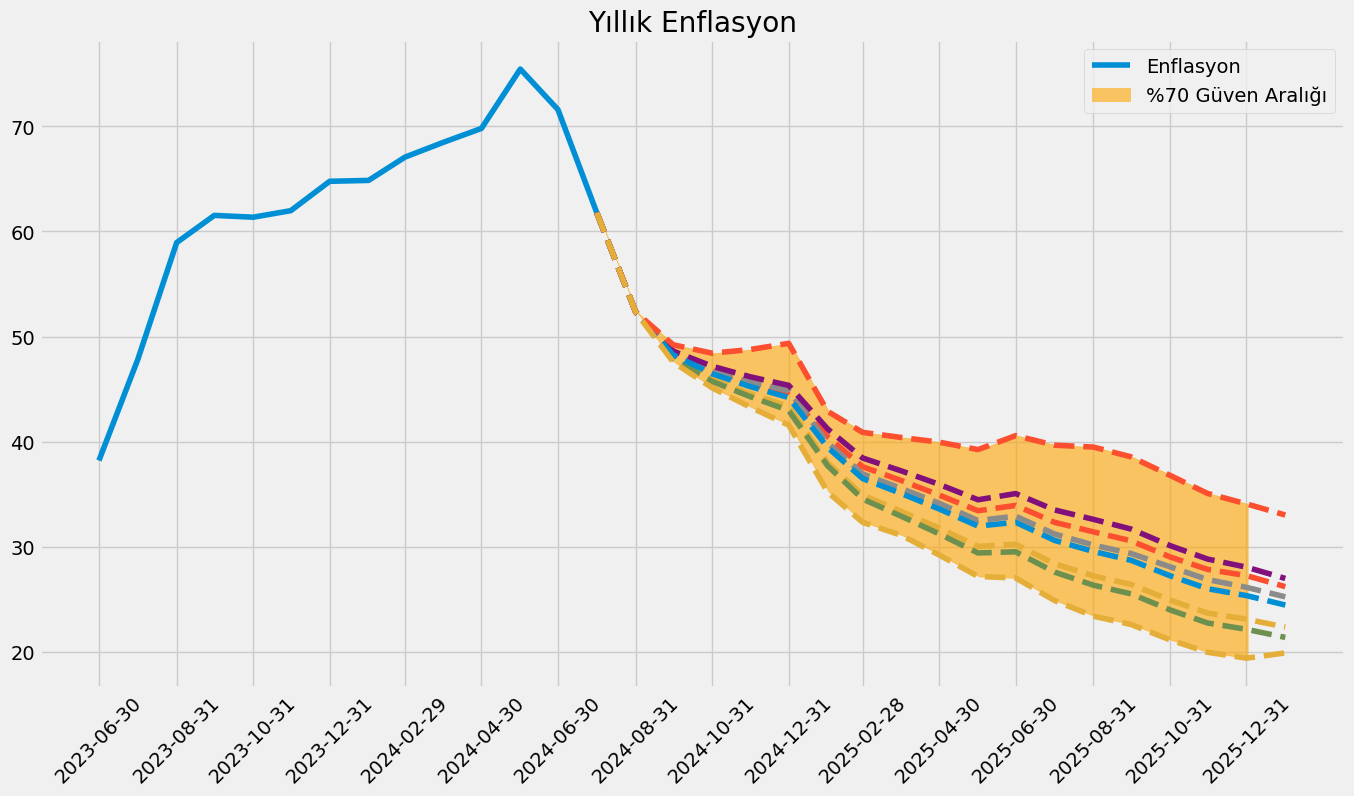

In [100]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,8))
plt.plot(dfas["Ortalama"].loc["2023-06-30":"2024-08-30"],label="Enflasyon")
plt.plot(dfas.loc["2024-07-30":],'--')
plt.fill_between(dfas.loc["2024-07-30":].index.strftime("%Y-%m"), dfas["Max"].loc["2024-07-30":].shift(1), dfas["Min"].loc["2024-07-30":].shift(1), alpha=0.6, color='orange',label="%70 Güven Aralığı")
plt.legend(loc=0)
plt.xticks(dfas.loc["2023-06-30":].index[::2],rotation=45)
plt.title("Yıllık Enflasyon")
plt.show()

In [102]:
sonu12024=str(dfas["Ortalama"].loc["2024-12-31"])[:5]
min2024=str(dfas["Min"].loc["2024-12-31"])[:5]
max2024=str(dfas["Max"].loc["2024-12-31"])[:5]

In [103]:
params = {
    'series': "TP.PKAUO.S01.D.U",
    'startDate': "01-08-2024",
    'endDate': date.today().strftime("%d-%m-%Y"),
    'frequency': 5,
    'aggregationTypes': 'avg',
    'type': 'json'
}

url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'

response = requests.get(url=url, headers={'key': key})

# print(response.request.headers)

formatted_response = json.loads(response.content)

ay12sonra = formatted_response['items']
ay12sonra = pd.DataFrame(ay12sonra)


ay12sonra = ay12sonra.drop(columns=['UNIXTIME','Tarih'])
ay12sonra.columns = ['Beklenti']
ay12sonra['Beklenti'] = pd.to_numeric(ay12sonra['Beklenti'])
ay12sonra=ay12sonra.set_index(pd.date_range(start="2024-08-01",freq="M",periods=len(ay12sonra)))
ay12sonra=ay12sonra.dropna()
ay12sonra

,Beklenti
2024-08-31,43.31


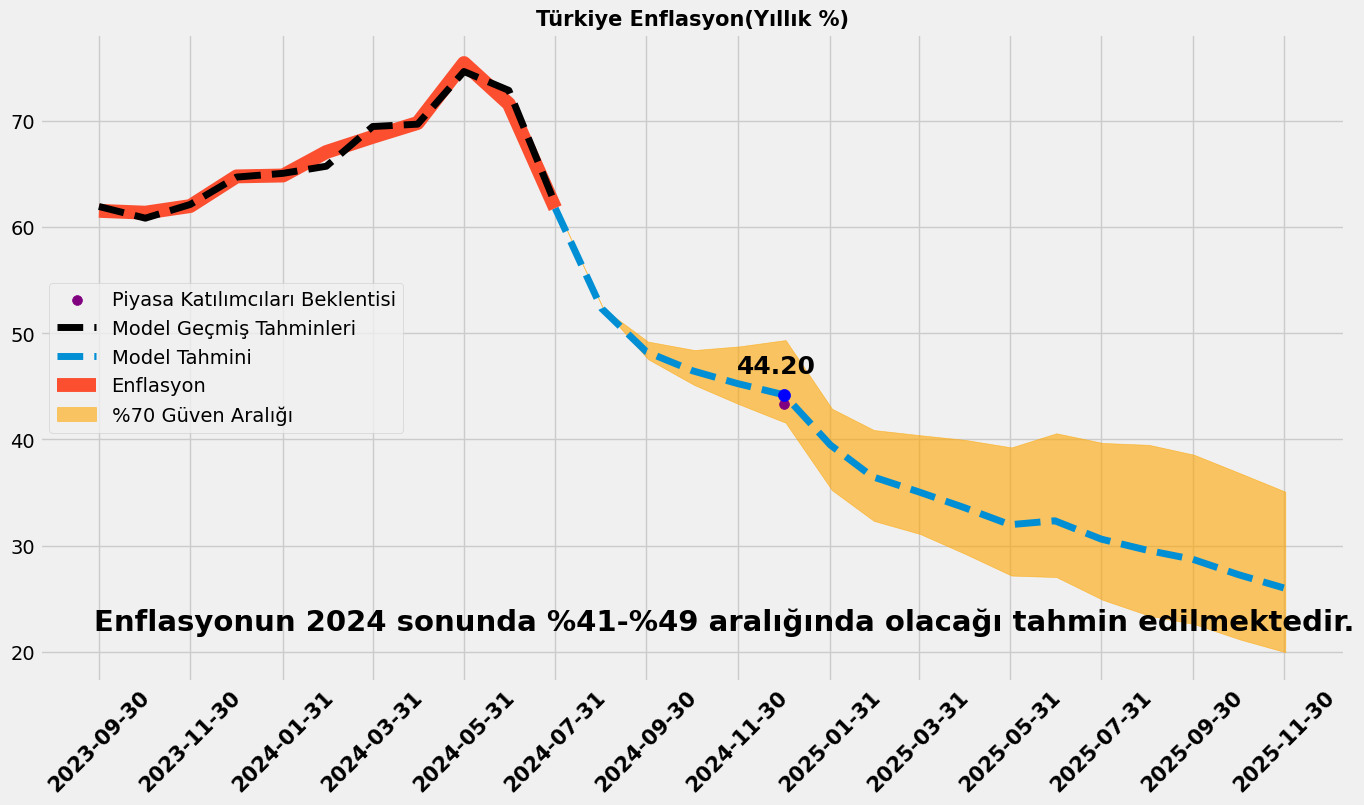

In [104]:
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(15,8))
plt.scatter(x=pd.to_datetime("2024-12-31"),y=ay12sonra["Beklenti"].values,color="purple",zorder=3,s=50,label="Piyasa Katılımcıları Beklentisi")
geçmiş=pd.DataFrame({"Tahmin":[61.94,60.84,62.13,64.71,65.06,65.73,69.47,69.69,74.65,72.87,62.17]})
geçmiş=geçmiş.set_index(pd.date_range(start="2023-09-30",periods=len(geçmiş),freq="M"))
plt.plot(geçmiş["Tahmin"],'--',label="Model Geçmiş Tahminleri",color="black",linewidth=5,zorder=3)
plt.scatter(x=dfas.loc["2024-12-31":].index[0],y=dfas["Ortalama"].loc["2024-12-31"],color='blue',zorder=4,s=75)
plt.plot(dfas["Ortalama"].loc["2024-07-30":"2025-12-30"],'--',label="Model Tahmini",linewidth=5)
plt.plot(dfas["Ortalama"].loc["2023-09-30":"2024-08-30"],label="Enflasyon",linewidth=10)
plt.fill_between(dfas.loc["2024-07-30":"2026-01-30"].index.strftime("%Y-%m"), dfas["Max"].loc["2024-07-30":"2026-01-30"].shift(1), dfas["Min"].loc["2024-07-30":"2026-01-30"].shift(1), alpha=0.6, color='orange',label="%70 Güven Aralığı")
annotation_date = mdates.datestr2num('2024-11')
plt.text(mdates.datestr2num('2025-01'), float(sonu12024)+2, sonu12024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(annotation_date, 22, f"Enflasyonun 2024 sonunda %{min2024[:2]}-%{max2024[:2]} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='center',fontweight='bold')
plt.xticks(dfas.loc["2023-09-30":"2025-12-30"].index[::2],rotation=45,fontsize=15,fontweight="bold")
plt.title("Türkiye Enflasyon(Yıllık %)",fontsize=15,fontweight="bold")
plt.legend(loc=6)
plt.savefig('forecast.png')
plt.savefig("./forecasts/"+date.today().strftime("%d-%m-%Y")+'.png')
plt.show()

In [105]:
predictions.columns=["NN1","NN2","NN3","NN4","NN5","Ortalama"]

In [106]:
modelaylık=cari.iloc[-1:,:-2]
modelaylık

,NN0,NN1,NN2,NN3,NN4,Ortalama
2024-08-31,2.836999,2.630666,2.850659,2.569132,2.833851,2.721864


In [107]:

aylık=pd.concat([data["TÜFE"][:-1],predictions["Ortalama"]],axis=0)
aylık

2014-03-31    1.125608
2014-04-30    1.344970
2014-05-31    0.395224
2014-06-30    0.310791
2014-07-31    0.454414
                ...   
2025-09-30    1.282553
2025-10-31    1.012161
2025-11-30    1.437698
2025-12-31    1.646188
2026-01-31    2.452909
Length: 143, dtype: float64

In [108]:
aylık.to_csv("C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv")

In [109]:
modelaylık.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/modelaylık.csv')

In [110]:
yıllıktahmin1=dfas


yıllıktahmin1.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '2023-09'),
  Text(1, 0, '2023-10'),
  Text(2, 0, '2023-11'),
  Text(3, 0, '2023-12'),
  Text(4, 0, '2024-01'),
  Text(5, 0, '2024-02'),
  Text(6, 0, '2024-03'),
  Text(7, 0, '2024-04'),
  Text(8, 0, '2024-05'),
  Text(9, 0, '2024-06'),
  Text(10, 0, '2024-07')])

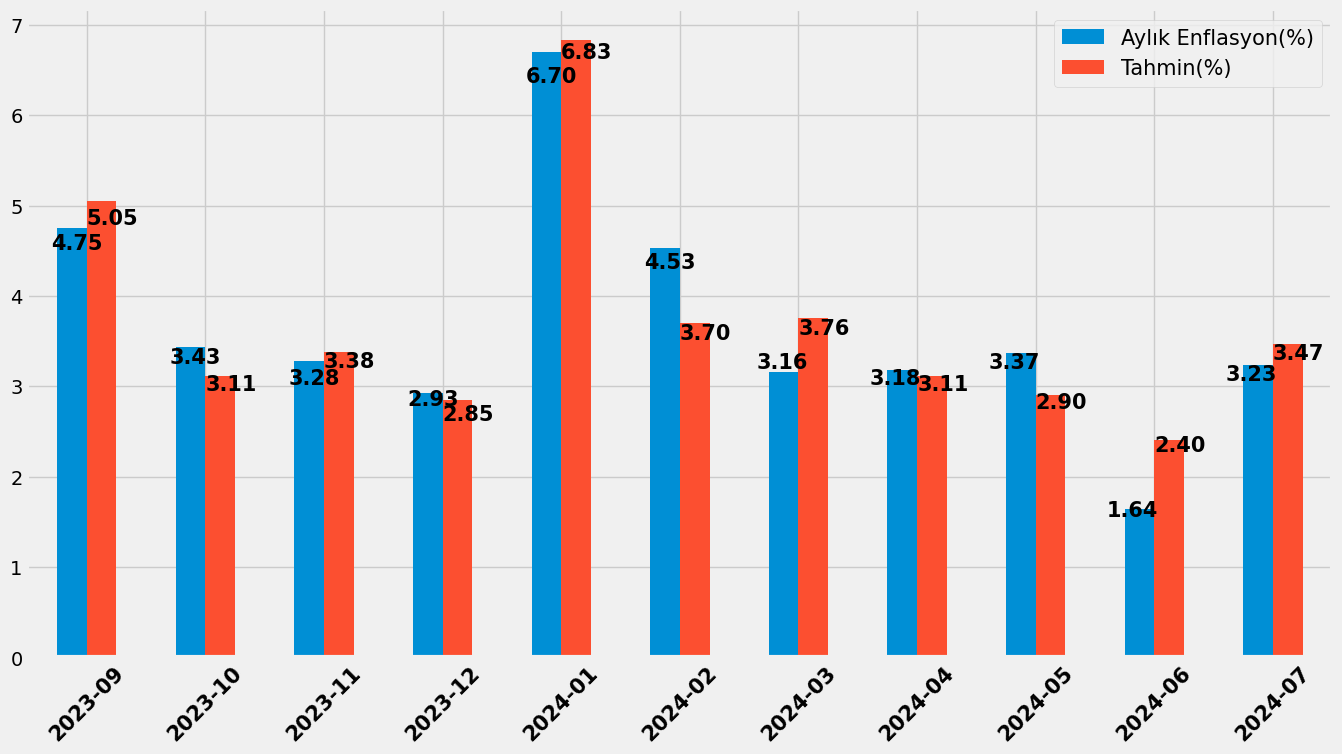

In [308]:
import matplotlib.axes as ax
gecmis=pd.DataFrame({"Aylık Enflasyon(%)":[4.75,3.43,3.28,2.93,6.70,4.53,3.16,3.18,3.37,1.64,3.23],"Tahmin(%)":[5.05,3.11,3.38,2.85,6.83,3.70,3.76,3.11,2.90,2.40,3.47]})
gecmis=gecmis.set_index(pd.date_range(start="2023-09-30",periods=11,freq="M"))
gecmis=gecmis.set_index(gecmis.index.strftime("%Y-%m"))
gecmis.plot(kind="bar",figsize=(15,8))
plt.annotate("4.75",xy=(-0.3,gecmis.iloc[0,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("5.05",xy=(0,gecmis.iloc[0,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.43",xy=(0.7,gecmis.iloc[1,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(1,gecmis.iloc[1,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.28",xy=(1.7,gecmis.iloc[2,0]*0.92),fontweight="bold",fontsize=15)
plt.annotate("3.38",xy=(2,gecmis.iloc[2,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.93",xy=(2.7,gecmis.iloc[3,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.85",xy=(3,gecmis.iloc[3,1]*0.92),fontweight="bold",fontsize=15)
plt.annotate("6.70",xy=(3.7,gecmis.iloc[4,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("6.83",xy=(4,gecmis.iloc[4,1]*0.97),fontweight="bold",fontsize=15)
plt.annotate("4.53",xy=(4.7,gecmis.iloc[5,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.70",xy=(5,gecmis.iloc[5,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.16",xy=(5.65,gecmis.iloc[6,1]*0.85),fontweight="bold",fontsize=15)
plt.annotate("3.76",xy=(6,gecmis.iloc[6,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.18",xy=(6.6,gecmis.iloc[7,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.11",xy=(7,gecmis.iloc[7,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.37",xy=(7.6,gecmis.iloc[8,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.90",xy=(8,gecmis.iloc[8,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("1.64",xy=(8.6,gecmis.iloc[9,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("2.40",xy=(9,gecmis.iloc[9,1]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.23",xy=(9.6,gecmis.iloc[10,0]*0.95),fontweight="bold",fontsize=15)
plt.annotate("3.47",xy=(10,gecmis.iloc[10,1]*0.95),fontweight="bold",fontsize=15)

plt.legend(fontsize=15)
plt.xticks(rotation=45,fontweight="bold",fontsize=15,color="black")

In [ ]:
aylıktahmin=modelaylık["Ortalama"]
aylıktahmin=aylıktahmin.loc[:"2025-07-31"]

Text(11.75, 1.7079183265370668, '1.79')

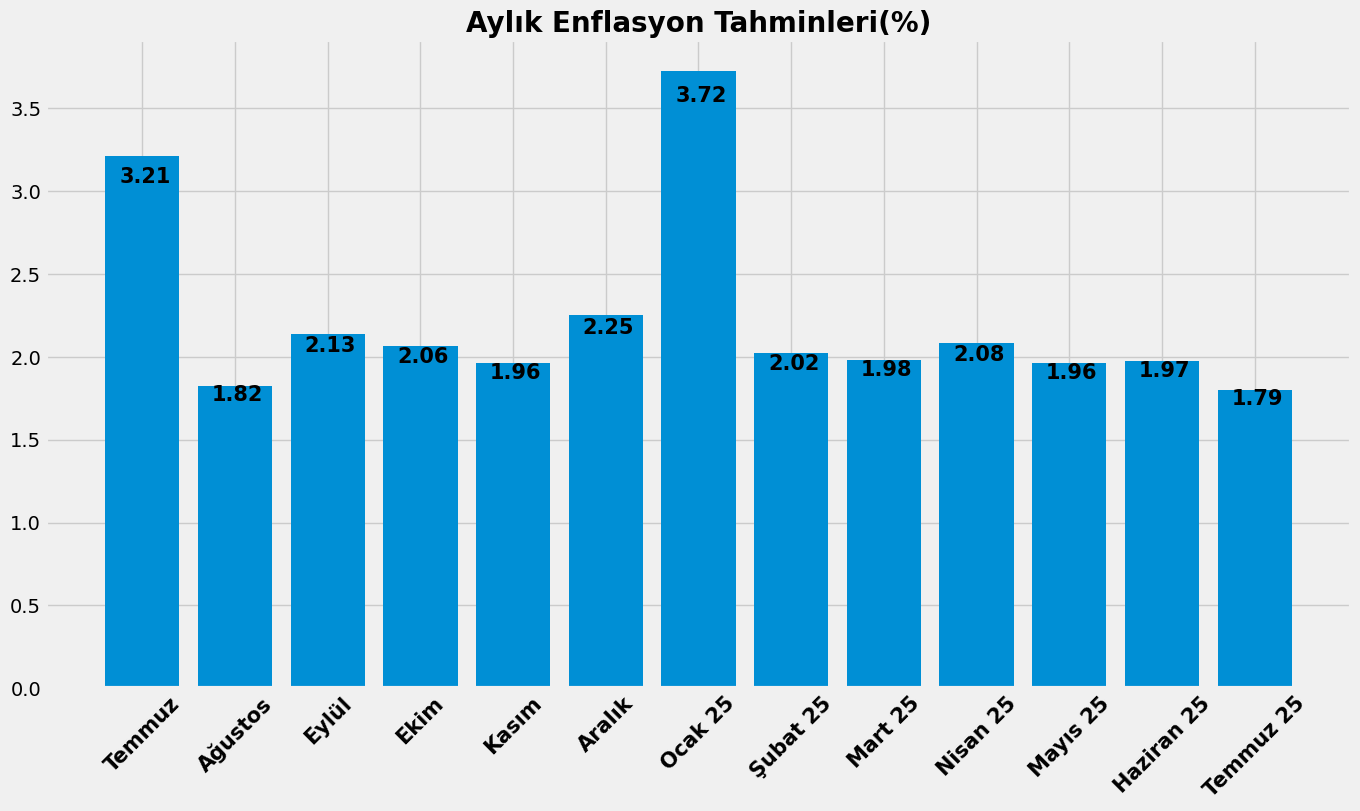

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(x=["Temmuz","Ağustos","Eylül","Ekim","Kasım","Aralık","Ocak 25","Şubat 25","Mart 25","Nisan 25","Mayıs 25","Haziran 25","Temmuz 25"],height=aylıktahmin.values)
plt.xticks(rotation=45,fontweight="bold",color="black",fontsize=15)
plt.title("Aylık Enflasyon Tahminleri(%)",fontweight="bold",fontsize=20)
plt.annotate(str(aylıktahmin.iloc[0])[:4],xy=(-0.25,aylıktahmin.iloc[0]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[1])[:4],xy=(0.75,aylıktahmin.iloc[1]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[2])[:4],xy=(1.75,aylıktahmin.iloc[2]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[3])[:4],xy=(2.75,aylıktahmin.iloc[3]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[4])[:4],xy=(3.75,aylıktahmin.iloc[4]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[5])[:4],xy=(4.75,aylıktahmin.iloc[5]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[6])[:4],xy=(5.75,aylıktahmin.iloc[6]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[7])[:4],xy=(6.75,aylıktahmin.iloc[7]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[8])[:4],xy=(7.75,aylıktahmin.iloc[8]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[9])[:4],xy=(8.75,aylıktahmin.iloc[9]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[10])[:4],xy=(9.75,aylıktahmin.iloc[10]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[11])[:4],xy=(10.75,aylıktahmin.iloc[11]*0.95),fontweight="bold",fontsize=15)
plt.annotate(str(aylıktahmin.iloc[12])[:4],xy=(11.75,aylıktahmin.iloc[12]*0.95),fontweight="bold",fontsize=15)



